In [1]:
!pip install -q langchain langgraph transformers accelerate

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/AMA/solution/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-11 19:21:42.270527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 19:21:42.287545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752229302.304621 1275466 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752229302.310515 1275466 cuda_bl

In [3]:
from typing import TypedDict, Optional, Dict, Any, Annotated, List
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    input_section: str
    section_description: str
    math_concept: str = ""
    parameters: Optional[Dict[str, Any]]
    hint_type: str = "" # none, svg, formula, both
    generated_code: Optional[str]
    comments: str = ""
    formulas: Optional[Dict[str, str]]

In [4]:
sections_info = {
    "직선 알아보기": {
        "description": "직선을 보고 이름을 붙이며, 직선의 개념을 이해한다.",
        "math_concept": "직선",
        "hint_type": "svg",
    },
    "각 알아보기": {
        "description": "각의 구성 요소(꼭짓점, 변)를 알고 각을 인식할 수 있다.",
        "math_concept": "각",
        "hint_type": "svg",
    },
    "직각 알아보기": {
        "description": "직각을 판단하고, 직각과 다른 각을 구별할 수 있다.",
        "math_concept": "직각",
        "parameters": {"size": 90},
        "hint_type": "svg",
    },
    "직각삼각형 알아보기": {
        "description": "직각삼각형을 식별하고, 구성 요소(변, 각)를 이해한다.",
        "math_concept": "직각삼각형",
        "hint_type": "svg",
    },
    "직사각형의 특징 알아보기": {
        "description": "직사각형을 다른 사각형과 구별하고 그 특징을 설명할 수 있다.",
        "math_concept": "직사각형",
        "hint_type": "svg",
    },
    "정사각형의 특징 알아보기": {
        "description": "정사각형을 다른 사각형과 구별하고 그 특징을 설명할 수 있다.",
        "math_concept": "정사각형",
        "hint_type": "svg",
    },
    "원의 반지름과 지름 알아보기": {
        "description": "원의 반지름과 지름의 관계를 알고, 직접 측정하거나 구할 수 있다.",
        "math_concept": "원",
        "hint_type": "both",
    },
    "지름의 성질 알아보기": {
        "description": "지름과 반지름의 관계를 바탕으로 길이를 비교하거나 구한다.",
        "math_concept": "원",
        "hint_type": "both",
    },
    "원 그리기": {
        "description": "컴퍼스를 이용하여 정확한 원을 그리고 반지름/지름을 표시할 수 있다.",
        "math_concept": "원",
        "hint_type": "svg",
    },
    "원을 이용하여 여러 가지 모양 그리기": {
        "description": "원의 특성을 이용해 창의적인 도형이나 패턴을 구성한다.",
        "math_concept": "여러 가지 모양(원)",
        "hint_type": "svg",
    },
    "각의 크기 비교하기": {
        "description": "직각, 예각, 둔각 등을 비교하여 각의 크기를 판단한다.",
        "math_concept": "각",
        "hint_type": "svg"
    },
    "각도기를 이용하여 각도 재기": {
        "description": "각도기를 바르게 사용하여 각의 크기를 정확히 잴 수 있다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도를 나타내는 단위 알아보기": {
        "description": "각의 크기를 도(°) 단위로 표현하고, 단위 개념을 이해한다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도기와 자를 이용하여 각 그리기": {
        "description": "각도기와 자를 이용해 주어진 각도를 정확히 그릴 수 있다.",
        "math_concept": "각",
        "hint_type": "svg",
    },
    "예각과 둔각 알아보기": {
        "description": "주어진 각을 예각, 직각, 둔각으로 분류할 수 있다.",
        "math_concept": "예각과 둔각",
        "hint_type": "svg",
    },
    "각도를 어림하고 각도기로 재어 확인하기": {
        "description": "주어진 각도를 어림하고 각도기로 재어 확인한다.",
        "math_concept": "각도",
        "hint_type": "svg",
    },
    "각도의 합 또는 차의 활용": {
        "description": "주어진 상황에서 두 각의 크기를 더하거나 빼는 문제를 해결한다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "두 각도의 차 구하기": {
        "description": "두 각도를 큰 각에서 작은 각을 빼서 더 작은 각을 만들 수 있다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "두 각도의 합 구하기": {
        "description": "두 각도를 더하여 더 큰 각을 만들 수 있다.",
        "math_concept": "각도의 합/차",
        "hint_type": "formula",
    },
    "삼각형에서 나머지 한 각의 크기 구하기": {
        "description": "삼각형의 세 각의 합이 180°인 사실을 이용하여 두 각의 크기가 주어졌을 때 나머지 한 각의 크기를 구할 수 있다.",
        "math_concept": "삼각형의 내각의 합",
        "hint_type": "formula",
    },
    "삼각형의 세 각의 크기의 합 구하기": {
        "description": "삼각형의 세 각의 크기의 합을 구하여 삼각형의 내각의 합이 180°인 사실을 확인한다.",
        "math_concept": "삼각형의 내각의 합",
        "hint_type": "formula",
    },
    "사각형의 나머지 한 각의 크기 구하기": {
        "description": "사각형의 네 각의 합이 360°인 사실을 이용하여 세 각의 크기가 주어졌을 때 나머지 한 각의 크기를 구할 수 있다.",
        "math_concept": "사각형의 내각의 합",
        "hint_type": "formula",
    },
    "사각형의 네 각의 크기의 합 구하기": {
        "description": "사각형의 네 각의 크기의 합을 구하여 사각형의 내각의 합이 360°인 사실을 확인한다.",
        "math_concept": "사각형의 내각의 합",
        "hint_type": "formula",
    },
    "삼각형의 변의 길이에 따라 분류하기": {
        "description": "삼각형의 변의 길이에 따라 일반삼각형, 이등변삼각형과 정삼각형으로 분류할 수 있다.",
        "math_concept": "삼각형 분류(변)",
        "hint_type": "svg",
    },
    "이등변삼각형 알아보기": {
        "description": "삼각형에서 두 변의 길이가 같은 이등변삼각형을 이해한다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "이등변삼각형의 성질 알아보기": {
        "description": "삼각형에서 두 변의 길이가 같은 이등변삼각형의 성질을 이해한다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "각을 이용하여 이등변삼각형 그리기": {
        "description": "한 선분의 양 끝에서 각각 마주보는 방향으로 같은 각도로 선분을 그어 이등변삼각형을 그릴 수 있다.",
        "math_concept": "이등변삼각형",
        "hint_type": "svg",
    },
    "정삼각형 알아보기": {
        "description": "삼각형에서 세 변의 길이가 같은 정삼각형을 이해한다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "정삼각형의 성질 알아보기": {
        "description": "정삼각형의 각과 변의 성질을 설명하고 활용할 수 있다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "각을 이용하여 정삼각형 그리기": {
        "description": "한 선분의 양 끝에서 각각 마주보는 방향으로 60°로 선분을 그어 정삼각형을 그릴 수 있다.",
        "math_concept": "정삼각형",
        "hint_type": "svg",
    },
    "삼각형을 각의 크기에 따라 분류하기": {
        "description": "삼각형을 각의 크기에 따라 예각삼각형, 직각삼각형, 둔각삼각형으로 올바르게 분류할 수 있다.",
        "math_concept": "삼각형 분류(각)",
        "hint_type": "svg",
    },
    "예각삼각형 알아보기": {
        "description": "세 각이 모두 예각인 예각삼각형을 식별하고 특징을 이해한다.",
        "math_concept": "예각삼각형",
        "hint_type": "svg",
    },
    "둔각삼각형 알아보기": {
        "description": "삼각형의 세 각 중 하나가 둔각인 둔각삼각형을 구별하고 특징을 설명할 수 있다.",
        "math_concept": "둔각삼각형",
        "hint_type": "svg",
    },
    "삼각자와 각도기를 이용한 수선 긋기": {
        "description": "도구를 이용해 주어진 점에서 직선에 수선을 정확히 그릴 수 있다.",
        "math_concept": "수선",
        "hint_type": "svg",
    },
    "수직": {
        "description": "수직의 개념을 이해하고 도형에서 수직선을 찾거나 그릴 수 있다.",
        "math_concept": "수직",
        "hint_type": "svg",
    },
    "평행 알아보기": {
        "description": "평행선의 정의를 이해하고 구별할 수 있다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "삼각자를 사용하여 평행선 긋기": {
        "description": "삼각자를 사용해 정확하게 평행선을 그릴 수 있다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "주어진 거리의 평행선 긋기": {
        "description": "자와 삼각자를 활용해 주어진 거리만큼 떨어진 평행선을 그린다.",
        "math_concept": "평행선",
        "hint_type": "svg",
    },
    "평행선 사이의 거리 알아보기": {
        "description": "평행선 사이의 거리를 측정하고 설명할 수 있다.",
        "math_concept": "평행선 사이의 거리",
        "hint_type": "svg",
    },
    "직사각형의 성질 알아보기": {
        "description": "직사각형의 정의와 성질을 알고 도형을 분류한다.",
        "math_concept": "직사각형의 성질",
        "hint_type": "svg",
        
    },
    "정사각형의 성질 알아보기": {
        "description": "정사각형의 정의와 변, 각, 대각선의 성질을 이해하고 다른 사각형과 구별할 수 있다.",
        "math_concept": "정사각형의 성질",
        "hint_type": "svg",
        
    },
    "직사각형과 정사각형의 성질 활용": {
        "description": "두 도형의 성질을 바탕으로 실생활 문제를 해결한다.",
        "math_concept": "직사각형/정사각형의 성질 활용",
        "hint_type": "svg",
    },
    "사다리꼴 알아보기": {
        "description": "사다리꼴의 정의와 기본 성질을 이해한다.",
        "math_concept": "사다리꼴",
        "hint_type": "svg",
    },
    "평행사변형 알아보기": {
        "description": "평행사변형을 정의하고 특징을 파악한다.",
        "math_concept": "평행사변형",
        "hint_type": "svg",
    },
    "평행사변형의 성질 알아보기": {
        "description": "평행사변형의 성질을 이해하고 구분할 수 있다.",
        "math_concept": "평행사변형",
        "hint_type": "svg",
    },
    "마름모 알아보기": {
        "description": "마름모의 정의와 성질을 알고 구별할 수 있다.",
        "math_concept": "마름모",
        "hint_type": "svg",
    },
    "마름모의 성질 알아보기": {
        "description": "마름모의 대각선 성질을 이해하고 활용한다.",
        "math_concept": "마름모",
        "hint_type": "svg",
    },
}

In [5]:
def classify_sections(state: GeometryState) -> GeometryState:
    """
    소단원(Section)을 보고 힌트를 제공하는데 필요한 수학 개념과 관련된 인자, 힌트 유형(none, svg, formula, both)을 분류한다
    """

    section = state["input_section"]
    section_info = sections_info[section]

    state["section_description"] = section_info["description"]
    state["math_concept"] = section_info["math_concept"]
    if "parameters" in section_info.keys():
        state["parameters"] = section_info["parameters"]
    if "expressions" in section_info.keys():
        state["expressions"] = section_info["expressions"]
    state["hint_type"] = section_info["hint_type"]

    return state    

In [6]:
def activate_nodes_by_state(state: GeometryState) -> list[str]:
    """
    소단원(Section)을 보고 분류된 정보가 기입된 state를 확인하여 힌트 생성에 필요한 노드를 선택한다
    """

    activated_nodes = ["generate_comments"]
    hint_type = state["hint_type"]
    if hint_type == "svg":
        activated_nodes.append("generate_code")
    elif hint_type == "formula":
        activated_nodes.append("generate_formulas")
    elif hint_type == "both":
        activated_nodes.extend(["generate_code", "generate_formulas"])
    else: # hint_type == "none"
        pass

    return activated_nodes

In [7]:
def gen_lines_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    곧은선(선분, 반직선, 직선)의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자
    
    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    
    x0, y0 = svg_frame // 4, svg_frame // 4
    x1, y1 = svg_frame // 4, svg_frame // 2
    x2, y2 = svg_frame // 4, (svg_frame * 3) // 4

    distance = svg_frame // 2

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 20}" font-size="{svg_frame // 20}" text-anchor="middle">곧은선</text>
    <text x="{svg_frame // 2}" y="{(svg_frame * 4) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="{x0}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x0 + distance}" cy="{y0}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 반직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 9) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">반직선</text>
    <circle cx="{x1}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x1 + distance}" cy="{y1}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{x1}" y1="{y1}" x2="{svg_frame}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 직선 -->
    <text x="{svg_frame // 2}" y="{(svg_frame * 14) // 20}" font-size="{svg_frame // 20}" text-anchor="middle">직선</text>
    <circle cx="{x2}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <circle cx="{x2 + distance}" cy="{y2}" r="1" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="0" y1="{y2}" x2="{svg_frame}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''
    
    return svg_content

In [8]:
import math

def gen_curves_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    굽은선(곡선)의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    
    svg_content = f'''
    <svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">굽은선</text>
    <!-- 복잡한 S자 곡선 (두 개의 Cubic Bézier) -->
    <path d="M {svg_frame // 5},{(svg_frame * 4) // 5}
    C {svg_frame // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 5} {(svg_frame * 4) // 5},{svg_frame // 2}
    C {(svg_frame * 4) // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{(svg_frame * 4) // 5} {svg_frame // 5},{svg_frame // 5}"
    stroke="{stroke}" fill="none" stroke-width="{stroke_width}"/>
    </svg>
    '''
    return svg_content

In [9]:
import math
import random

def gen_angle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    기준선과 기울어진 선 + 각도를 나타내는 보조선을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    if concept == "각" or concept == "각도":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(1, 179)
    elif concept == "예각":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(1, 89)
    elif concept == "둔각":
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else random.randint(91, 179)
    else:
        degree = parameters.get("size") if (parameters is not None) and (parameters.get("size") is not None) else 90
    
    # 기준점
    x0, y0 = svg_frame // 4 if degree <= 90 else svg_frame // 2, (svg_frame * 2) // 3

    # 기준선 끝점 (수평)
    line_length = svg_frame // 2
    x1 = x0 + line_length
    y1 = y0

    # 기울어진 선 끝점
    rad = math.radians(degree)
    x2 = x0 + line_length * math.cos(-rad)
    y2 = y0 + line_length * math.sin(-rad)

    if degree != 90:
        # 호의 시작점 (반지름만큼 떨어진 점)
        arc_radius = svg_frame // 10
        arc_start_x = x0 + arc_radius * math.cos(-rad)
        arc_start_y = y0 + arc_radius * math.sin(-rad)

        # 호의 끝점 (반지름과 각도로 계산)
        arc_end_x = x0 + arc_radius
        arc_end_y = y0

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{(svg_frame * 3) // 4}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x0}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_start_x},{arc_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_end_x},{arc_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x0 + arc_radius * 1.25 * math.cos(-rad / 2)}" y="{y0 + arc_radius * 1.25 * math.sin(-rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{degree}°</text>
        </svg>
        '''
    else:
        # 직각 보조선
        epsilon = svg_frame // 10

        h1 = x2 + epsilon
        h2 = y0 - epsilon

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0 - epsilon}" y1="{y0}" x2="{x1}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x2}" y1="{y0}" x2="{x2}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 직각 보조선 -->
        <polyline points="{h1}, {y0} {h1}, {h2} {x2} {h2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        </svg>
        '''

    return svg_content

In [10]:
import random
import math

def gen_acute_obtuse_angles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    예각과 둔각의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    acute_deg = random.randint(1, 89) # 예각
    obtuse_deg = random.randint(91, 179) # 둔각

    # 기준점
    x_acute_0, y_acute_0 = svg_frame // 3, (svg_frame * 2) // 5
    x_obtuse_0, y_obtuse_0 = svg_frame // 2, (svg_frame * 4) // 5

    # 기준선 끝점 (수평)
    line_length = svg_frame // 4
    x_acute_1, y_acute_1 = x_acute_0 + line_length, y_acute_0
    x_obtuse_1, y_obtuse_1 = x_obtuse_0 + line_length, y_obtuse_0

    # 기울어진 선 끝점
    acute_rad, obtuse_rad = math.radians(acute_deg), math.radians(obtuse_deg)
    x_acute_2, y_acute_2 = x_acute_0 + line_length * math.cos(-acute_rad), y_acute_0 + line_length * math.sin(-acute_rad)
    x_obtuse_2, y_obtuse_2 = x_obtuse_0 + line_length * math.cos(-obtuse_rad), y_obtuse_0 + line_length * math.sin(-obtuse_rad)
    
    # 호의 시작점 (반지름만큼 떨어진 점)
    arc_radius = svg_frame // 10
    arc_acute_start_x, arc_acute_start_y = x_acute_0 + arc_radius * math.cos(-acute_rad), y_acute_0 + arc_radius * math.sin(-acute_rad)
    arc_obtuse_start_x, arc_obtuse_start_y = x_obtuse_0 + arc_radius * math.cos(-obtuse_rad), y_obtuse_0 + arc_radius * math.sin(-obtuse_rad)

    # 호의 끝점 (반지름과 각도로 계산)
    arc_acute_end_x, arc_acute_end_y = x_acute_0 + arc_radius, y_acute_0
    arc_obtuse_end_x, arc_obtuse_end_y = x_obtuse_0 + arc_radius, y_obtuse_0

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 예각 -->
        <text x="{svg_frame // 2}" y="{(svg_frame * 7) // 40}" font-size="{svg_frame // 25}" text-anchor="middle">예각</text>
        <!-- 기준선 -->
        <line x1="{x_acute_0}" y1="{y_acute_0}" x2="{x_acute_1}" y2="{y_acute_1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x_acute_0}" y1="{y_acute_0}" x2="{x_acute_2}" y2="{y_acute_2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_acute_start_x},{arc_acute_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_acute_end_x},{arc_acute_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x_acute_0 + arc_radius * 1.25 * math.cos(-acute_rad / 2)}" y="{y_acute_0 + arc_radius * 1.25 * math.sin(-acute_rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{acute_deg}°</text>
        <!-- 둔각 -->
        <text x="{svg_frame // 2}" y="{(svg_frame * 21) // 40}" font-size="{svg_frame // 25}" text-anchor="middle">둔각</text>
        <!-- 기준선 -->
        <line x1="{x_obtuse_0}" y1="{y_obtuse_0}" x2="{x_obtuse_1}" y2="{y_obtuse_1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기울어진 선 -->
        <line x1="{x_obtuse_0}" y1="{y_obtuse_0}" x2="{x_obtuse_2}" y2="{y_obtuse_2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 각도 호 -->
        <path d="M {arc_obtuse_start_x},{arc_obtuse_start_y} A {arc_radius},{arc_radius} 0 0,1 {arc_obtuse_end_x},{arc_obtuse_end_y}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선 -->
        <text x="{x_obtuse_0 + arc_radius * 1.25 * math.cos(-obtuse_rad / 2)}" y="{y_obtuse_0 + arc_radius * 1.25 * math.sin(-obtuse_rad / 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{obtuse_deg}°</text>
        </svg>
    '''
    
    return svg_content

In [11]:
def gen_right_triangle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직각삼각형의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2

    # 기준점
    rt_base = (svg_frame * 2) // 3
    rt_height = svg_frame // 2
    x0, y0 = svg_frame // 6, (svg_frame * 5) // 6
    x1, y1 = min(x0 + rt_base, (svg_frame * 5) // 6), y0
    x2, y2 = x1, max(y1 - rt_height, svg_frame // 3)

    epsilon = min(rt_base, rt_height) // 10

    h1 = x1 - epsilon
    h2 = y1 - epsilon
    
    # SVG 내용
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 직각삼각형 -->
    <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="{h1}, {y1} {h1}, {h2} {x1} {h2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
    <!-- 보조선들 -->
    <path d="M {x0}, {y0} Q {(x0 + x1) // 2}, {((y0 + y1) // 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{(x0 + x1) // 2}" y="{((y0 + y1) // 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">밑변</text>
    <path d="M {x1}, {y1} Q {((x1 + x2) // 2) - epsilon}, {(y1 + y2) // 2} {x2}, {y2}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{((x1 + x2) // 2) - 1.2 * epsilon}" y="{(y1 + y2) // 2}" font-size="{svg_frame // 40}" text-anchor="middle">높이</text>
    <path d="M {x0}, {y0} Q {((x0 + x2) // 2) - epsilon}, {(y0 + y2) // 2 - epsilon} {x2}, {y2}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{((x0 + x2) // 2) - 1.2 * epsilon}" y="{(y0 + y2) // 2 - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">빗변</text>
    </svg>
    '''
    return svg_content

In [12]:
def gen_rectangle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직사각형/정사각형의 prototype을 그리는 코드 문자열을 생성합니다.

    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    x = svg_frame // 5
    y = svg_frame // 5
    if concept == "정사각형":
        r_width = (svg_frame * 3) // 5
        r_height = r_width
        svg_height = svg_frame
    else:
        r_width = (svg_frame * 3) // 5
        r_height = r_width // 2
        svg_height = min(500, ((y + r_height) * 5) // 4)

    # 사각형이 가로로 중앙에 위치하도록
    x = (svg_frame - r_width) // 2

    # 직사각형, 정사각형에 따른 용어 변경
    if concept == "정사각형":
        base_term = "한변"
        height_term = "한변"
    else:
        base_term = "밑변"
        height_term = "높이"

    epsilon = min(r_width, r_height) // 5
    
    # svg_width = x + width + x, svg_height = y + height + y
    svg_content = f'''<svg width="{svg_frame}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <!-- 보조선들 -->
    <path d="M {x}, {y + r_height} Q {x + (r_width // 2)}, {y + r_height - epsilon} {x + r_width}, {y + r_height}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{x + (r_width // 2)}" y="{y + r_height - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">{base_term}</text>
    <path d="M {x + r_width}, {y} Q {x + r_width - epsilon}, {y + (r_height // 2)} {x + r_width}, {y + r_height}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{x + r_width - epsilon}" y="{y + (r_height // 2)}" font-size="{svg_frame // 40}" text-anchor="middle">{height_term}</text>
    <polyline points="{x + r_width}, {y + r_height - epsilon} {x + r_width - epsilon}, {y + r_height - epsilon} {x + r_width - epsilon} {y + r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
    </svg>'''
    return svg_content

In [13]:
def gen_circle_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    원의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"
    
    cx = svg_frame // 2
    cy = cx
    r = svg_frame // 3

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">원</text>
    <circle cx="{cx}" cy="{cy}" r="{r}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy}" r="{r // 50}" stroke="{stroke}" stroke-width="{stroke_width}" fill="black" />
    <line x1="{cx - r}" y1="{cy}" x2="{cx + r}" y2="{cy}" stroke="{stroke}" stroke-width="{stroke_width}" />
    <!-- 보조선 -->
    <path d="M {cx}, {cy} Q {cx + (r // 2)}, {cy - (r // 6)} {cx + r}, {cy}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{cx + (r // 2)}" y="{cy - (r // 6)}" font-size="{svg_frame // 40}" text-anchor="middle">반지름</text>
    <path d="M {cx - r}, {cy} Q {cx}, {cy + (r // 6)} {cx + r}, {cy}" fill="none" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
    <text x="{cx}" y="{cy + (r // 4)}" font-size="{svg_frame // 40}" text-anchor="middle">지름</text>
    </svg>
    '''

    return svg_content

In [14]:
def gen_flower_by_circles(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    원의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 꽃 그리기
    cx, cy = svg_frame // 2, svg_frame // 2
    cr = svg_frame // 14

    radius = svg_frame // 7

    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <circle cx="{cx}" cy="{cy}" r="{cr}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx + (cr + radius)}" cy="{cy}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx - (cr + radius)}" cy="{cy}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy - (cr + radius)}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    <circle cx="{cx}" cy="{cy + (cr + radius)}" r="{radius}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
    </svg>
    '''

    return svg_content

In [15]:
def gen_triangles_by_length(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    변의 길이에 따른 삼각형(이등변삼각형, 정삼각형)의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 이등변삼각형
    isosceles_rad = math.pi / 6
    isosceles_lateral = svg_frame // 2
    isosceles_x0, isosceles_y0 = svg_frame // 4, svg_frame // 4
    isosceles_x1, isosceles_y1 = isosceles_x0 + isosceles_lateral * math.cos((math.pi - isosceles_rad) / 2), isosceles_y0 + isosceles_lateral * math.sin((math.pi - isosceles_rad) / 2)
    isosceles_x2, isosceles_y2 = isosceles_x0 + isosceles_lateral * math.cos((math.pi + isosceles_rad) / 2), isosceles_y0 + isosceles_lateral * math.sin((math.pi + isosceles_rad) / 2)

    isosceles_epsilon = isosceles_lateral // 10
    isosceles_same_tick = isosceles_lateral // 30

    # 정삼각형
    equilateral_rad = math.pi / 3
    equilateral_lateral = svg_frame // 2
    equilateral_x0, equilateral_y0 = (svg_frame * 3) // 4, svg_frame // 4
    equilateral_x1, equilateral_y1 = equilateral_x0 + equilateral_lateral * math.cos(equilateral_rad), equilateral_y0 + equilateral_lateral * math.sin(equilateral_rad)
    equilateral_x2, equilateral_y2 = equilateral_x0 + equilateral_lateral * math.cos(2 * equilateral_rad), equilateral_y0 + equilateral_lateral * math.sin(2 * equilateral_rad)

    equilateral_epsilon = equilateral_lateral // 10
    equilateral_same_tick = equilateral_lateral // 30
    
    # SVG 코드
    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 아등변삼각형 -->
    <text x="{svg_frame // 4}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">이등변삼각형</text>
    <polygon points="{isosceles_x0},{isosceles_y0} {isosceles_x1},{isosceles_y1} {isosceles_x2},{isosceles_y2}" stroke="{stroke}"
    stroke-width="{stroke_width}" fill="none"/>
    <!-- 보조선들 -->
    <line x1="{(isosceles_x0 + isosceles_x1) / 2 - isosceles_same_tick * math.cos((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    y1="{(isosceles_y0 + isosceles_y1) / 2 - isosceles_same_tick * math.sin((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    x2="{(isosceles_x0 + isosceles_x1)/ 2 + isosceles_same_tick * math.cos((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    y2="{(isosceles_y0 + isosceles_y1) / 2 + isosceles_same_tick * math.sin((math.pi - isosceles_rad) / 2 + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(isosceles_x0 + isosceles_x2) / 2 - isosceles_same_tick * math.cos((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    y1="{(isosceles_y0 + isosceles_y2) / 2 - isosceles_same_tick * math.sin((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    x2="{(isosceles_x0 + isosceles_x2)/ 2 + isosceles_same_tick * math.cos((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    y2="{(isosceles_y0 + isosceles_y2) / 2 + isosceles_same_tick * math.sin((math.pi + isosceles_rad) / 2 + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    
    <!-- 정삼각형 -->
    <text x="{(svg_frame * 3) // 4}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">정삼각형</text>
    <polygon points="{equilateral_x0},{equilateral_y0} {equilateral_x1},{equilateral_y1} {equilateral_x2},{equilateral_y2}" stroke="{stroke}"
    stroke-width="{stroke_width}" fill="none"/>
    <!-- 보조선들 -->
    <line x1="{(equilateral_x0 + equilateral_x1) / 2 - equilateral_same_tick * math.cos(equilateral_rad + math.pi / 2)}"
    y1="{(equilateral_y0 + equilateral_y1) / 2 - equilateral_same_tick * math.sin(equilateral_rad + math.pi / 2)}"
    x2="{(equilateral_x0 + equilateral_x1)/ 2 + equilateral_same_tick * math.cos(equilateral_rad + math.pi / 2)}"
    y2="{(equilateral_y0 + equilateral_y1) / 2 + equilateral_same_tick * math.sin(equilateral_rad + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(equilateral_x1 + equilateral_x2) / 2 - equilateral_same_tick * math.cos(math.pi / 2)}"
    y1="{(equilateral_y1 + equilateral_y2) / 2 - equilateral_same_tick * math.sin(math.pi / 2)}"
    x2="{(equilateral_x1 + equilateral_x2) / 2 + equilateral_same_tick * math.cos(math.pi / 2)}"
    y2="{(equilateral_y1 + equilateral_y2) / 2 + equilateral_same_tick * math.sin(math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    <line x1="{(equilateral_x0 + equilateral_x2) / 2 - equilateral_same_tick * math.cos(2 * equilateral_rad + math.pi / 2)}"
    y1="{(equilateral_y0 + equilateral_y2) / 2 - equilateral_same_tick * math.sin(2 * equilateral_rad + math.pi / 2)}"
    x2="{(equilateral_x0 + equilateral_x2) / 2 + equilateral_same_tick * math.cos(2 * equilateral_rad + math.pi / 2)}"
    y2="{(equilateral_y0 + equilateral_y2) / 2 + equilateral_same_tick * math.sin(2 * equilateral_rad + math.pi / 2)}"
    stroke="{stroke}" stroke-width="{stroke_width}" />
    </svg>
    '''

    return svg_content

In [16]:
import math

def gen_isosceles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    이등변삼각형과 정삼각형의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "정삼각형":
        # 정삼각형
        rad = math.pi / 3
        lateral = svg_frame // 2
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos(rad), y0 + lateral * math.sin(rad)
        x2, y2 = x0 + lateral * math.cos(2 * rad), y0 + lateral * math.sin(2 * rad)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 정삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <path d="M {x0}, {y0} Q {(x0 + x1) / 2 + epsilon}, {((y0 + y1) / 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}"
        stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{(x0 + x1) / 2 + 1.5 * epsilon}" y="{((y0 + y1) / 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">한변</text>
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos(rad + math.pi / 2)}" y1="{(y0 + y1) / 2 - same_tick * math.sin(rad + math.pi / 2)}"
        x2="{(x0 + x1)/ 2 + same_tick * math.cos(rad + math.pi / 2)}" y2="{(y0 + y1) / 2 + same_tick * math.sin(rad + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x1 + x2) / 2 - same_tick * math.cos(math.pi / 2)}" y1="{(y1 + y2) / 2 - same_tick * math.sin(math.pi / 2)}"
        x2="{(x1 + x2) / 2 + same_tick * math.cos(math.pi / 2)}" y2="{(y1 + y2) / 2 + same_tick * math.sin(math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos(2 * rad + math.pi / 2)}" y1="{(y0 + y2) / 2 - same_tick * math.sin(2 * rad + math.pi / 2)}"
        x2="{(x0 + x2) / 2 + same_tick * math.cos(2 * rad + math.pi / 2)}" y2="{(y0 + y2) / 2 + same_tick * math.sin(2 * rad + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <path d="M {x0 + epsilon * math.cos(rad)},{y0 + epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1
        {x0 + epsilon * math.cos(2 * rad)},{y0 + epsilon * math.sin(2 * rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x1 - epsilon},{y2} A {epsilon},{epsilon} 0 0,1
        {x1 + epsilon * math.cos(-(math.pi + rad) / 2)},{y1 + epsilon * math.sin(-(math.pi + rad) / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x2 + epsilon * math.cos(-math.pi/3)},{y2 + epsilon * math.sin(-math.pi/3)} A {epsilon},{epsilon} 0 0,1
        {x2 + epsilon},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    else:
        # 이등변삼각형
        rad = math.pi / 6
        lateral = svg_frame // 2
        x0, y0 = svg_frame // 2, svg_frame // 4
        x1, y1 = x0 + lateral * math.cos((math.pi - rad) / 2), y0 + lateral * math.sin((math.pi - rad) / 2)
        x2, y2 = x0 + lateral * math.cos((math.pi + rad) / 2), y0 + lateral * math.sin((math.pi + rad) / 2)

        epsilon = lateral // 10
        same_tick = lateral // 30

        # SVG 내용
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="{x0},{y0} {x1},{y1} {x2},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 보조선들 -->
        <path d="M {x0}, {y0} Q {(x0 + x1) // 2 + epsilon}, {((y0 + y1) // 2) - epsilon} {x1}, {y1}" fill="none" stroke="{stroke}"
        stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{(x0 + x1) // 2 + epsilon}" y="{((y0 + y1) // 2) - epsilon}" font-size="{svg_frame // 40}" text-anchor="middle">등변</text>
        <line x1="{(x0 + x1) / 2 - same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}"
        y1="{(y0 + y1) / 2 - same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}"
        x2="{(x0 + x1)/ 2 + same_tick * math.cos((math.pi - rad) / 2 + math.pi / 2)}"
        y2="{(y0 + y1) / 2 + same_tick * math.sin((math.pi - rad) / 2 + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(x0 + x2) / 2 - same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}"
        y1="{(y0 + y2) / 2 - same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}"
        x2="{(x0 + x2)/ 2 + same_tick * math.cos((math.pi + rad) / 2 + math.pi / 2)}"
        y2="{(y0 + y2) / 2 + same_tick * math.sin((math.pi + rad) / 2 + math.pi / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" />
        <path d="M {x1 - epsilon},{y2} A {epsilon},{epsilon} 0 0,1
        {x1 + epsilon * math.cos(-(math.pi + rad) / 2)},{y1 + epsilon * math.sin(-(math.pi + rad) / 2)}"
        stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x2 + epsilon * math.cos(-(math.pi - rad) / 2)},{y2 + epsilon * math.sin(-(math.pi - rad) / 2)} A {epsilon},{epsilon} 0 0,1
        {x2 + epsilon},{y2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
        
    return svg_content

In [17]:
import math

def gen_triangles_by_angle(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    각의 크기에 따른 삼각형(예각삼각형, 직각삼각형, 둔각삼각형)의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    # 예각삼각형
    x_acute_0, y_acute_0 = svg_frame // 6, svg_frame // 4
    x_acute_1, y_acute_1 = svg_frame // 10, (svg_frame * 4) // 5
    x_acute_2, y_acute_2 = (svg_frame * 3) // 10, (svg_frame * 4) // 5

    epsilon = svg_frame // 30

    # 직각삼각형
    x_right_0, y_right_0 = (svg_frame * 2) // 5, svg_frame // 4
    x_right_1, y_right_1 = (svg_frame * 2) // 5, (svg_frame * 4) // 5
    x_right_2, y_right_2 = (svg_frame * 3) // 5, (svg_frame * 4) // 5

    # 둔각삼각형
    rad = math.radians(75)
    lateral = (svg_frame * 11) // 20
    x_obtuse_1, y_obtuse_1 = (svg_frame * 7) // 10, (svg_frame * 4) // 5
    x_obtuse_2, y_obtuse_2 = (svg_frame * 5) // 6, (svg_frame * 4) // 5
    x_obtuse_0, y_obtuse_0 = x_obtuse_2 + lateral * math.cos(-rad), y_obtuse_2 + lateral * math.sin(-rad)

    svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
    <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
    <!-- 예각삼각형 -->
    <text x="{svg_frame // 6}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">예각삼각형</text>
    <polygon points="{x_acute_0},{y_acute_0} {x_acute_1},{y_acute_1} {x_acute_2},{y_acute_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <!-- 직각삼각형 -->
    <text x="{svg_frame // 2}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">직각삼각형</text>
    <polygon points="{x_right_0},{y_right_0} {x_right_1},{y_right_1} {x_right_2},{y_right_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <polyline points="{x_right_1 + epsilon}, {y_right_1} {x_right_1 + epsilon}, {y_right_1 - epsilon} {x_right_1} {y_right_1 - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
    <!-- 둔각삼각형 -->
    <text x="{(svg_frame * 5) // 6}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">둔각삼각형</text>
    <polygon points="{x_obtuse_0},{y_obtuse_0} {x_obtuse_1},{y_obtuse_1} {x_obtuse_2},{y_obtuse_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    <path d="M {x_obtuse_2 - epsilon},{y_obtuse_2} A {epsilon},{epsilon} 0 0,1 {x_obtuse_2 + epsilon * math.cos(-rad)},{y_obtuse_2 + epsilon * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
    </svg>
    '''
        
    return svg_content

In [18]:
import math

def gen_acute_obtuse_triangles(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    예각삼각형, 둔각삼각형의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "둔각삼각형":
        x_0, y_0 = svg_frame * 3 // 4, svg_frame // 4 
        x_1, y_1 = svg_frame // 5, (svg_frame * 4) // 5
        x_2, y_2 = (svg_frame * 3) // 5, (svg_frame * 4) // 5

        rad = math.atan((y_2 - y_0) / (x_2 - x_0))
        epsilon = svg_frame // 30
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x_0},{y_0} {x_1},{y_1} {x_2},{y_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x_2 - epsilon},{y_2} A {epsilon},{epsilon} 0 0,1 {x_2 + epsilon * math.cos(rad)},{y_2 + epsilon * math.sin(rad)}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    else:
        # 예각 삼각형
        x_0, y_0 = svg_frame // 3, svg_frame // 4 
        x_1, y_1 = svg_frame // 5, (svg_frame * 4) // 5
        x_2, y_2 = (svg_frame * 4) // 5, (svg_frame * 4) // 5
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x_0},{y_0} {x_1},{y_1} {x_2},{y_2}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''

    return svg_content

In [19]:
def gen_parallel_lines_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    평행선의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if "거리" in concept:
        x0, y0 = svg_frame // 4, (svg_frame * 3) // 4
        x1, y1 = x0, svg_frame // 4
        distance = svg_frame // 2

        distance_x = x0 + (distance // 3)
        epsilon = svg_frame // 15

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기준선과 평행선 -->
        <line x1="{x1}" y1="{y1}" x2="{x1 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 거리 -->
        <line x1="{distance_x}" y1="{y0}" x2="{distance_x}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <polyline points="{distance_x + epsilon}, {y0} {distance_x + epsilon}, {y0 - epsilon} {distance_x} {y0 - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <path d="M {distance_x}, {y0} Q {distance_x - epsilon}, {((y0 + y1) // 2)} {distance_x}, {y1}" fill="none" stroke="{stroke}"
        stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <text x="{distance_x - epsilon}" y="{((y0 + y1) // 2)}" font-size="{svg_frame // 40}" text-anchor="middle">거리</text>
        </svg>
        '''
        pass
    else: # 평행선
        x0, y0 = svg_frame // 4, (svg_frame * 3) // 4
        y1 = svg_frame // 2
        y2 = svg_frame // 4
        distance = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 기준선 -->
        <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 기준선과 평행선들 -->
        <line x1="{x0}" y1="{y1}" x2="{x0 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0}" y1="{y2}" x2="{x0 + distance}" y2="{y2}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''

        # Animation - Flutter에서 지원 안 해서 불가능함
        # svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        # <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        # <!-- 기준선 -->
        # <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # <!-- 움직이는 선: 그룹에 애니메이션 -->
        # <g>
        # <line x1="{x0}" y1="{y0}" x2="{x0 + distance}" y2="{y0}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # <animateTransform attributeName="transform" type="translate" from="0 0" to="0 {y1 - y0}" dur="4s" repeatCount="indefinite" />
        # </g>
        # <!-- 기준선과 평행선 -->
        # <line x1="{x0}" y1="{y1}" x2="{x0 + distance}" y2="{y1}" stroke="{stroke}" stroke-width="{stroke_width}" />
        # </svg>
        # '''

    return svg_content

In [20]:
def gen_rectangle_property(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    직사각형, 정사각형의 성질의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if "직사각형/정사각형" in concept:
        # 직사각형
        r_width = (svg_frame * 3) // 10
        r_height = r_width * 2

        # 직사각형의 위치하도록
        r_x, r_y = (svg_frame - r_width) // 5, svg_frame // 4

        # 정사각형
        s_width = (svg_frame * 3) // 10
        s_height = s_width

        # 정사각형의 위치
        s_x, s_y = (svg_frame + s_width) // 2, svg_frame // 4

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 3
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <!-- 직사각형 -->
        <text x="{svg_frame * 7 // 24}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">직사각형</text>
        <rect x="{r_x}" y="{r_y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{r_x + epsilon}, {r_y} {r_x + epsilon}, {r_y + epsilon} {r_x} {r_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + r_width - epsilon}, {r_y} {r_x + r_width - epsilon}, {r_y + epsilon} {r_x + r_width} {r_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + epsilon}, {r_y + r_height} {r_x + epsilon}, {r_y + r_height - epsilon} {r_x} {r_y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{r_x + r_width - epsilon}, {r_y + r_height} {r_x + r_width - epsilon}, {r_y + r_height - epsilon} {r_x + r_width} {r_y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{r_x + (r_width / 2) - tick_interval}" y1="{r_y - same_tick}" x2="{r_x + (r_width / 2) - tick_interval}" y2="{r_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) - tick_interval}" y1="{r_y + r_height - same_tick}" x2="{r_x + (r_width / 2) - tick_interval}" y2="{r_y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) + tick_interval}" y1="{r_y - same_tick}" x2="{r_x + (r_width / 2) + tick_interval}" y2="{r_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + (r_width / 2) + tick_interval}" y1="{r_y + r_height - same_tick}" x2="{r_x + (r_width / 2) + tick_interval}" y2="{r_y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x - same_tick}" y1="{r_y + (r_height / 2)}" x2="{r_x + same_tick}" y2="{r_y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{r_x + r_width - same_tick}" y1="{r_y + (r_height / 2)}" x2="{r_x + r_width + same_tick}" y2="{r_y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 정사각형 -->
        <text x="{svg_frame * 19 // 24}" y="{svg_frame // 5}" font-size="{svg_frame // 25}" text-anchor="middle">정사각형</text>
        <rect x="{s_x}" y="{s_y}" width="{s_width}" height="{s_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{s_x + epsilon}, {s_y} {s_x + epsilon}, {s_y + epsilon} {s_x} {s_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + s_width - epsilon}, {s_y} {s_x + s_width - epsilon}, {s_y + epsilon} {s_x + s_width} {s_y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + epsilon}, {s_y + s_height} {s_x + epsilon}, {s_y + s_height - epsilon} {s_x} {s_y + s_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{s_x + s_width - epsilon}, {s_y + s_height} {s_x + s_width - epsilon}, {s_y + s_height - epsilon} {s_x + s_width} {s_y + s_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{s_x + (s_width / 2) - tick_interval}" y1="{s_y - same_tick}" x2="{s_x + (s_width / 2) - tick_interval}" y2="{s_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) - tick_interval}" y1="{s_y + s_height - same_tick}" x2="{s_x + (s_width / 2) - tick_interval}" y2="{s_y + s_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) + tick_interval}" y1="{s_y - same_tick}" x2="{s_x + (s_width / 2) + tick_interval}" y2="{s_y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + (s_width / 2) + tick_interval}" y1="{s_y + s_height - same_tick}" x2="{s_x + (s_width / 2) + tick_interval}" y2="{s_y + s_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x - same_tick}" y1="{s_y + (s_height / 2) - tick_interval}" x2="{s_x + same_tick}" y2="{s_y + (s_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x - same_tick}" y1="{s_y + (s_height / 2) + tick_interval}" x2="{s_x + same_tick}" y2="{s_y + (s_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + s_width - same_tick}" y1="{s_y + (s_height / 2) - tick_interval}" x2="{s_x + s_width + same_tick}" y2="{s_y + (s_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{s_x + s_width - same_tick}" y1="{s_y + (s_height / 2) + tick_interval}" x2="{s_x + s_width + same_tick}" y2="{s_y + (s_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
    elif "정사각형" in concept:
        r_width = (svg_frame * 3) // 5
        r_height = r_width

        # 사각형이 가로로 중앙에 위치하도록
        x, y = (svg_frame - r_width) // 2, svg_frame // 5

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 5
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{x + epsilon}, {y} {x + epsilon}, {y + epsilon} {x} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y} {x + r_width - epsilon}, {y + epsilon} {x + r_width} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + epsilon}, {y + r_height} {x + epsilon}, {y + r_height - epsilon} {x} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y + r_height} {x + r_width - epsilon}, {y + r_height - epsilon} {x + r_width} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2) - tick_interval}" x2="{x + same_tick}" y2="{y + (r_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2) + tick_interval}" x2="{x + same_tick}" y2="{y + (r_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2) - tick_interval}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2) - tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2) + tick_interval}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2) + tick_interval}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''
    else: # 직사각형
        r_width = (svg_frame * 3) // 5
        r_height = r_width // 2

        # 사각형이 가로로 중앙에 위치하도록
        x, y = (svg_frame - r_width) // 2, svg_frame // 5

        epsilon = min(r_width, r_height) // 8
        same_tick = epsilon // 3
        tick_interval = same_tick // 2
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <rect x="{x}" y="{y}" width="{r_width}" height="{r_height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="{fill}" />
        <!-- 직각 보조선들 -->
        <polyline points="{x + epsilon}, {y} {x + epsilon}, {y + epsilon} {x} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y} {x + r_width - epsilon}, {y + epsilon} {x + r_width} {y + epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + epsilon}, {y + r_height} {x + epsilon}, {y + r_height - epsilon} {x} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        <polyline points="{x + r_width - epsilon}, {y + r_height} {x + r_width - epsilon}, {y + r_height - epsilon} {x + r_width} {y + r_height - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" />
        <!-- 등변 보조선들 -->
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) - tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) - tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + (r_width / 2) + tick_interval}" y1="{y + r_height - same_tick}" x2="{x + (r_width / 2) + tick_interval}" y2="{y + r_height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x - same_tick}" y1="{y + (r_height / 2)}" x2="{x + same_tick}" y2="{y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x + r_width - same_tick}" y1="{y + (r_height / 2)}" x2="{x + r_width + same_tick}" y2="{y + (r_height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        </svg>
        '''

    return svg_content

In [21]:
import math

def gen_various_quadrangles_prototype(concept:str, parameters:Optional[Dict[str,Any]]=None) -> str:
    """
    사다리꼴, 평행사변형, 마름모의 prototype을 그리는 코드 문자열을 생성합니다.
    
    Parameters:
        concept (str): 수학 개념
        parameters (Optional[Dict[str, Any]]): 수학 개념의 prototype을 위한 추가 인자

    Returns:
        svg_content (str): SVG 코드 문자열
    """

    # SVG config
    svg_frame=500
    stroke="black"
    stroke_width=2
    fill="none"

    if concept == "사다리꼴":
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        
        upper_width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + upper_width},{y0} {x0 + upper_width + extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    elif concept == "평행사변형":
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        
        width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        rad = math.atan(height / extend)

        same_tick = svg_frame // 50
        tick_interval = same_tick // 4

        epsilon = svg_frame // 20
        
        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + width},{y0} {x0 + width - extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="{x0 + (width / 2) - tick_interval}" y1="{y0 - same_tick}" x2="{x0 + (width / 2) - tick_interval}" y2="{y0 + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) + tick_interval}" y1="{y0 - same_tick}" x2="{x0 + (width / 2) + tick_interval}" y2="{y0 + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) -extend - tick_interval}" y1="{y0 + height - same_tick}" x2="{x0 + (width / 2) -extend - tick_interval}" y2="{y0 + height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + (width / 2) -extend + tick_interval}" y1="{y0 + height - same_tick}" x2="{x0 + (width / 2) -extend + tick_interval}" y2="{y0 + height + same_tick}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 - (extend / 2) - same_tick}" y1="{y0 + (height / 2)}" x2="{x0 - (extend / 2) + same_tick}" y2="{y0 + (height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{x0 + width - (extend / 2) - same_tick}" y1="{y0 + (height / 2)}" x2="{x0 + width - (extend / 2) + same_tick}" y2="{y0 + (height / 2)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 등각 보조선 -->
        <path d="M {x0 + epsilon},{y0} A {epsilon},{epsilon} 0 0,1 {x0 + epsilon * math.cos(math.pi - rad)},{y0 + epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 + width - extend - epsilon},{y0 + height} A {epsilon},{epsilon} 0 0,1 {x0 + width - extend + epsilon * math.cos(-rad)},{y0 + height+ epsilon * math.sin(-rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 + width + epsilon * math.cos(math.pi - rad)},{y0 + epsilon * math.sin(math.pi - rad)} A {epsilon},{epsilon} 0 0,1 {x0 + width - epsilon},{y0}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {x0 - extend + epsilon * math.cos(-rad)},{y0 + height + epsilon * math.sin(-rad)} A {epsilon},{epsilon} 0 0,1 {x0 - extend + epsilon},{y0 + height}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''
    elif concept == "마름모":
        # 상단 꼭짓점
        tx, ty = svg_frame // 2, svg_frame // 4
        # 좌측 꼭짓점
        lx, ly = svg_frame // 6, svg_frame // 2
        # 우측 꼭짓점
        rx, ry = (svg_frame * 5) // 6, svg_frame // 2
        # 하단 꼭짓점
        bx, by = svg_frame // 2, (svg_frame * 3) // 4

        same_tick = svg_frame // 50
        rad = math.atan((ly - ty) / (tx - lx))
        epsilon = svg_frame // 25

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{tx},{ty} {rx},{ry} {bx},{by} {lx},{ly}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="{(lx + tx) / 2 - same_tick * math.cos(math.pi / 2 - rad)}" y1="{(ly + ty) / 2 - same_tick * math.sin(math.pi / 2 - rad)}" x2="{(lx + tx) / 2 + same_tick * math.cos(math.pi / 2 - rad)}" y2="{(ly + ty) / 2 + same_tick * math.sin(math.pi / 2 - rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(rx + bx) / 2 - same_tick * math.cos(math.pi / 2 - rad)}" y1="{(ry + by) / 2 - same_tick * math.sin(math.pi / 2 - rad)}" x2="{(rx + bx) / 2 + same_tick * math.cos(math.pi / 2 - rad)}" y2="{(ry + by) / 2 + same_tick * math.sin(math.pi / 2 - rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(lx + bx) / 2 - same_tick * math.cos(-rad)}" y1="{(ly + by) / 2 - same_tick * math.sin(-rad)}" x2="{(lx + bx) / 2 + same_tick * math.cos(-rad)}" y2="{(ly + by) / 2 + same_tick * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <line x1="{(rx + tx) / 2 - same_tick * math.cos(-rad)}" y1="{(ry + ty) / 2 - same_tick * math.sin(-rad)}" x2="{(rx + tx) / 2 + same_tick * math.cos(-rad)}" y2="{(ry + ty) / 2 + same_tick * math.sin(-rad)}" stroke="{stroke}" stroke-width="{stroke_width}" />
        <!-- 등각 보조선 -->
        <path d="M {tx + epsilon * math.cos(rad)},{ty + epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1 {tx + epsilon * math.cos(math.pi - rad)},{ty + epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {bx - epsilon * math.cos(rad)},{by - epsilon * math.sin(rad)} A {epsilon},{epsilon} 0 0,1 {bx - epsilon * math.cos(math.pi - rad)},{by - epsilon * math.sin(math.pi - rad)}" stroke="red" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {lx + epsilon * math.cos(-rad)},{ly + epsilon * math.sin(-rad)} A {epsilon},{epsilon} 0 0,1 {lx + epsilon * math.cos(rad)},{ly + epsilon * math.sin(rad)}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        <path d="M {rx + epsilon * math.cos(math.pi - rad)},{ry + epsilon * math.sin(math.pi - rad)} A {epsilon},{epsilon} 0 0,1 {rx + epsilon * math.cos(-math.pi + rad)},{ry + epsilon * math.sin(-math.pi + rad)}" stroke="blue" stroke-width="{stroke_width}" fill="none"/>
        <!-- 대각 보조선 -->
        <line x1="{tx}" y1="{ty}" x2="{bx}" y2="{by}" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <line x1="{lx}" y1="{ly}" x2="{rx}" y2="{ry}" stroke="{stroke}" stroke-width="{stroke_width}" stroke-dasharray="5,3" />
        <polyline points="{tx + epsilon}, {ly} {tx + epsilon}, {ly - epsilon} {tx} {ly - epsilon}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none" /> 
        </svg>
        '''
    else: # 일반사각형
        # 좌상단 좌표
        x0, y0 = svg_frame // 3, svg_frame // 4
        upper_width = svg_frame // 3
        extend = svg_frame // 6
        height = svg_frame // 2

        svg_content = f'''<svg width="{svg_frame}" height="{svg_frame}" xmlns="http://www.w3.org/2000/svg">
        <text x="{svg_frame // 2}" y="{svg_frame // 10}" font-size="{svg_frame // 20}" text-anchor="middle">{concept}</text>
        <polygon points="{x0},{y0} {x0 + upper_width},{y0 + extend} {x0 + upper_width + extend},{y0 + height} {x0 - extend},{y0 + height}" stroke="{stroke}" stroke-width="{stroke_width}" fill="none"/>
        </svg>
        '''

    return svg_content

In [22]:
def generate_code_node(state: GeometryState) -> GeometryState:
    
    concept = state["math_concept"]
    parameters = state["parameters"] if "parameters" in state.keys() else None

    if concept == "직선":
        code = gen_lines_prototype(concept, parameters)
    elif concept == "각" or concept == "각도" or concept == "직각" or concept == "수직" or concept == "수선":
        code = gen_angle_prototype(concept, parameters)
    elif concept == "직각삼각형":
        code = gen_right_triangle_prototype(concept, parameters)
    elif concept == "직사각형" or concept == "정사각형":
        code = gen_rectangle_prototype(concept, parameters)
    elif concept == "원" or concept == "반지름" or concept == "지름":
        code = gen_circle_prototype(concept, parameters)
    elif concept == "여러 가지 모양(원)":
        code = gen_flower_by_circles(concept, parameters)
    elif concept == "예각과 둔각":
        code = gen_acute_obtuse_angles_prototype(concept, parameters)
    elif concept == "삼각형 분류(변)":
        code = gen_triangles_by_length(concept, parameters)
    elif concept == "이등변삼각형" or concept == "정삼각형":
        code = gen_isosceles_prototype(concept, parameters)
    elif concept == "삼각형 분류(각)":
        code = gen_triangles_by_angle(concept, parameters)
    elif concept == "예각삼각형" or concept == "둔각삼각형":
        code = gen_acute_obtuse_triangles(concept, parameters)
    elif concept == "평행선" or concept == "평행선 사이의 거리":
        code = gen_parallel_lines_prototype(concept, parameters)
    elif concept == "직사각형의 성질" or concept == "정사각형의 성질" or concept == "직사각형/정사각형의 성질 활용":
        code = gen_rectangle_property(concept, parameters)
    elif concept == "사다리꼴" or concept == "평행사변형" or concept == "마름모":
        code = gen_various_quadrangles_prototype(concept, parameters)
    else:
        code = f'''<svg width="{500}" height="{500}" xmlns="http://www.w3.org/2000/svg">
        <text x="{250}" y="{50}" font-size="{12}" text-anchor="middle"># {concept}을(를) 그리는 코드는 아직 구현되지 않았습니다.</text>
        </svg>
        '''

    # return {**state, "generated_code": code}
    return {"generated_code": code}

In [23]:
def generate_comments_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": '''
                당신은 초등학생들에게 수학을 가르쳐주는 친절한 초등학교 선생님입니다.
                {state["section_description"]}의 학습목표를 학생이 달성할 수 있도록 해당하는 개념에 대해 설명해주세요.
                다음 내용을 포함하여 반드시 총 500자 이내로 한국어로 설명해주세요.
                    - 정의
                    - 기본 성질(공식은 제외하세요)
                원주율은 반드시 π(\pi)가 아닌 3.14로하여 제공해주세요.
             '''
        },
        {
            "role": "user",
            "content": state["section_description"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # 답변 추출 로직
    decoded = decoded[decoded.find("[|assistant|]") + len("[|assistant|]"):]

    # state["comments"] = decoded

    return {"comments": decoded}

In [24]:
def generate_formulas_node(state: GeometryState) -> GeometryState:
    """
    소단원(Section)을 보고 힌트를 제공하는데 필요한 수학 공식을 제공한다
    """

    section = state["input_section"]
    formulas = {}

    if section in ["원의 반지름과 지름 알아보기", "지름의 성질 알아보기"]:
        formulas["반지름과 지름의 관계"] = "$\\mathrm{지름} = \\mathrm{반지름} \\times 2$"
    elif section in ["두 각도의 합 구하기", "두 각도의 차 구하기", "각도의 합 또는 차의 활용"]:
        formulas["두 각도의 합"] = "$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$"
        formulas["두 각도의 차"] = "$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$"
    elif section in ["삼각형의 세 각의 크기의 합 구하기", "삼각형에서 나머지 한 각의 크기 구하기"]:
        formulas["삼각형의 내각의 합"] = "$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$"
    elif section in ["사각형의 네 각의 크기의 합 구하기", "사각형의 나머지 한 각의 크기 구하기"]:
        formulas["사각형의 내각의 합"] = "$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$"

    state["formulas"] = formulas

    return state 

In [25]:
def merge_hints(state: GeometryState) -> GeometryState:
    return state

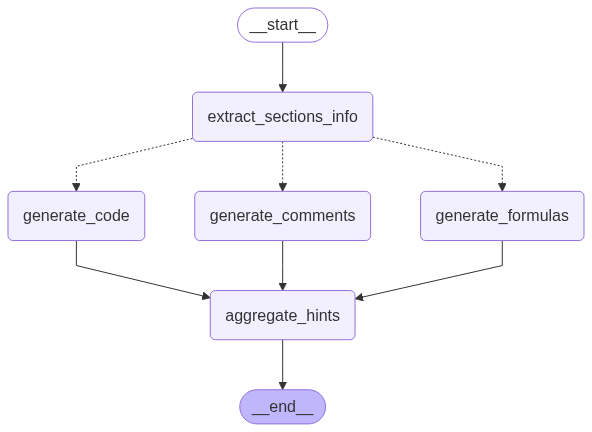

In [26]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_sections_info", classify_sections)
geometry_agent.add_node("generate_code", generate_code_node)
geometry_agent.add_node("generate_comments", generate_comments_node)
geometry_agent.add_node("generate_formulas", generate_formulas_node)
geometry_agent.add_node("aggregate_hints", merge_hints)

# 엣지 연결
geometry_agent.set_entry_point("extract_sections_info")
geometry_agent.add_conditional_edges(
    "extract_sections_info",
    activate_nodes_by_state,
    {
        "generate_code": "generate_code",
        "generate_comments": "generate_comments",
        "generate_formulas": "generate_formulas",
    }
)
geometry_agent.add_edge("generate_code", "aggregate_hints")
geometry_agent.add_edge("generate_comments", "aggregate_hints")
geometry_agent.add_edge("generate_formulas", "aggregate_hints")
geometry_agent.add_edge("aggregate_hints", END)

# 그래프 완성
app = geometry_agent.compile()
app

In [27]:
from IPython.display import SVG, display

def show_svg(svg_content):
    display(SVG(svg_content))

In [28]:
from IPython.display import Math, display

def show_formulas(formula):
    for key in formula.keys():
        display(Math(formula[key]))

In [29]:
inputs = [
    "직선 알아보기",
    "각 알아보기",
    "직각 알아보기",
    "직각삼각형 알아보기",
    "직사각형의 특징 알아보기",
    "정사각형의 특징 알아보기",
    "원의 반지름과 지름 알아보기",
    "지름의 성질 알아보기",
    "원 그리기",
    "원을 이용하여 여러 가지 모양 그리기",
    "각의 크기 비교하기",
    "각도기를 이용하여 각도 재기",
    "각도를 나타내는 단위 알아보기",
    "각도기와 자를 이용하여 각 그리기",
    "예각과 둔각 알아보기",
    "각도를 어림하고 각도기로 재어 확인하기",
    "각도의 합 또는 차의 활용",
    "두 각도의 차 구하기",
    "두 각도의 합 구하기",
    "삼각형에서 나머지 한 각의 크기 구하기",
    "삼각형의 세 각의 크기의 합 구하기",
    "사각형의 나머지 한 각의 크기 구하기",
    "사각형의 네 각의 크기의 합 구하기",
    "삼각형의 변의 길이에 따라 분류하기",
    "이등변삼각형 알아보기",
    "이등변삼각형의 성질 알아보기",
    "각을 이용하여 이등변삼각형 그리기",
    "정삼각형의 성질 알아보기",
    "정삼각형 알아보기",
    "각을 이용하여 정삼각형 그리기",
    "예각삼각형 알아보기",
    "삼각형을 각의 크기에 따라 분류하기",
    "둔각삼각형 알아보기",
    "삼각자와 각도기를 이용한 수선 긋기",
    "수직",
    "삼각자를 사용하여 평행선 긋기",
    "주어진 거리의 평행선 긋기",
    "평행 알아보기",
    "평행선 사이의 거리 알아보기",
    "직사각형의 성질 알아보기",
    "정사각형의 성질 알아보기",
    "직사각형과 정사각형의 성질 활용",
    "사다리꼴 알아보기",
    "평행사변형의 성질 알아보기",
    "평행사변형 알아보기",
    "마름모 알아보기",
    "마름모의 성질 알아보기",
    # "다각형과 다각형의 이름 알아보기",
    # "정다각형과 정다각형의 이름 알아보기",
    # "대각선의 성질 알아보기",
    # "대각선 알아보기",
    # "모양 만들기",
]

input_samples = inputs[:] # 일정 범위만 잘라서 테스트

입력된 소단원(section): 직선 알아보기
추출된 개념: 직선

생성된 설명:
 ### 직선의 개념 이해하기

#### 정의
직선은 평면 위에서 가장 간단하고 무한히 이어지는 형태의 도형입니다. 쉽게 말해, 직선은 한 점에서 시작해서 양쪽으로 무한히 뻗어나가는 선을 의미합니다. 이 선은 방향이 항상 일정하며, 어떤 두 점을 지나더라도 그 사이를 항상 같은 속도로 이동합니다.

#### 기본 성질
1. **무한히 이어짐**: 직선은 한쪽 끝에서 다른 끝으로 가더라도 끝이 없습니다. 즉, 어느 방향으로든 계속 뻗어나갈 수 있습니다.
   
2. **평행한 직선**: 같은 평면 위에 있는 두 직선이 서로 만나지 않고 항상 같은 거리를 유지하며 평행하게 위치할 수 있습니다. 이들은 방향이 완전히 동일합니다.

3. **교차점**: 두 직선이 서로 만나는 지점을 교차점이라고 합니다. 이 교차점에서 두 직선은 한 점에서만 만나게 됩니다.

4. **직선의 길이**: 직선의 길이는 무한히 길기 때문에, 우리가 실제로 측정하는 것은 그 길이의 일부 구간일 뿐입니다. 예를 들어, 직선의 일부분을 측정할 때는 그 구간의 길이를 구하게 됩니다.

이러한 성질들을 이해하면 직선이 어떻게 평면 위에서 움직이고 상호작용하는지 더 잘 파악할 수 있습니다. 직선에 대한 이러한 기본적인 이해는 기하학에서 매우 중요한 기초가 됩니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="25" font-size="25" text-anchor="middle">곧은선</text>
    <text x="250" y="100" font-size="25" text-anchor="middle">선분</text>
    <!-- 선분 -->
    <circle cx="125" cy="125" r="1" stroke="black" stroke-width="2" fill="black

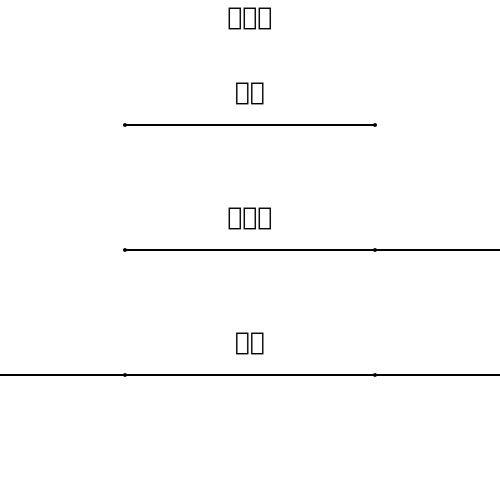

입력된 소단원(section): 각 알아보기
추출된 개념: 각

생성된 설명:
 ## 삼각형 친구들과 만나요! 🧑‍🏫

안녕하세요, 친구들! 오늘은 삼각형 친구들을 만나볼 거예요! 삼각형은 세 개의 변과 세 개의 꼭짓점으로 이루어져 있어요.

**1. 꼭짓점 (Vertex):** 삼각형의 모서리 부분을 꼭짓점이라고 해요. 마치 삼각형이 앉아있는 자리처럼 생각하면 돼요! 삼각형에는 세 개의 꼭짓점이 있어요.

**2. 변 (Side):** 꼭짓점을 잇는 선분을 변이라 부르죠. 삼각형 친구들은 세 개의 변으로 이루어져 있어요. 이 변들을 따라 움직이면 삼각형을 완성할 수 있답니다!

**각을 알아보는 방법**

삼각형 친구들은 세 개의 각으로 이루어져 있어요. 각은 꼭짓점에서 만나는 두 변이 이루는 공간을 말해요. 각의 크기를 측정하는 단위는 **도(°)**예요. 

삼각형 친구들을 보면서 꼭짓점에서 만나는 변의 길이와 각도를 관찰해보세요! 그러면 각을 쉽게 찾을 수 있을 거예요. 

예를 들어, 한 꼭짓점에서 두 변이 만나는 각도가 60도라면, 그 각을 **60°**라고 부르죠!

삼각형 친구들과 함께 즐겁게 배우면 수학이 훨씬 재미있어질 거예요! 💪

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="61.32260494430699" y2="168.98524275237318" stroke="black" stroke-width="2" />
        <!

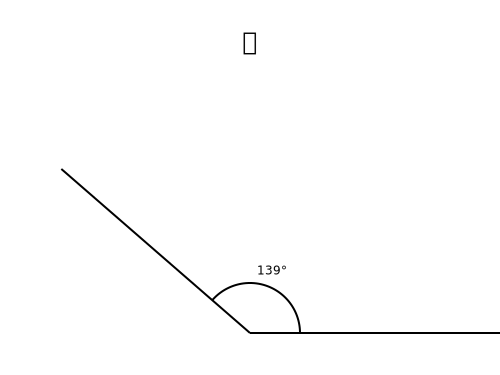

입력된 소단원(section): 직각 알아보기
추출된 개념: 직각

생성된 설명:
 ### 직각과 다른 각 구별하기: 초등학생을 위한 설명

**정의:**
직각은 평면 위에서 두 직선이 만나서 정확히 90도의 각도를 이루는 것을 말해요. 이 각도는 특별한 값으로 **π(\pi)** 대신 **3.14**로 표현되기도 하지만, 여기서는 주로 **90도**로 이해하는 것이 중요해요. 다른 각은 이 90도가 아닌 다양한 크기의 각도를 의미해요.

**기본 성질 및 구별 방법:**

1. **직각 (90도):**
   - **특징:** 직각은 가장 기본적인 각도 중 하나로, 두 직선이 서로 정확히 수직으로 만나는 모습을 보여줘요.
   - **예시:** 책상 모서리나 건물의 벽과 바닥이 만나는 부분이 직각을 이루고 있어요.

2. **예각 (0도 < 각 < 90도):**
   - **특징:** 예각은 0도에서 시작해서 90도 미만의 각도를 말해요. 이 각도들은 뾰족하거나 좁은 모양을 나타내요.
   - **예시:** 손가락을 펴서 가장 뾰족한 부분이 예각을 이루고 있어요.

3. **둔각 (90도 < 각 < 180도):**
   - **특징:** 둔각은 90도를 초과하고 180도 미만의 각도를 의미해요. 이 각도들은 넓게 퍼져 있는 모양을 보여줘요.
   - **예시:** 큰 삼각형이나 일부 건물의 지붕 각도가 둔각일 수 있어요.

**구별 방법:**
- **직각 찾기:** 두 선이 만나서 정확히 90도의 각을 이루는지 확인하면 돼요.
- **예각과 둔각 구별:** 각도를 눈으로 직접 보거나 간단한 도구를 사용해 측정해보세요. 예각은 뾰족하고 좁은 모양을, 둔각은 넓게 퍼져 있는 모양을 기억하면 도움이 돼요.

이렇게 직각과 다른 각을 구별하면서 공간 인식 능력과 각도 이해를 키울 수 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y

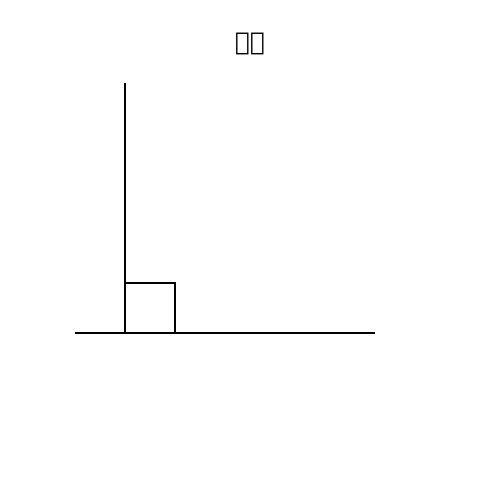

입력된 소단원(section): 직각삼각형 알아보기
추출된 개념: 직각삼각형

생성된 설명:
 ## 직각삼각형 탐험! 🧮

안녕하세요, 친구들! 오늘은 특별한 삼각형 친구인 **직각삼각형**을 알아볼 거예요!

**직각삼각형이란?**

직각삼각형은 이름처럼 **한 각이 직각(90도)**인 삼각형이에요. 마치 우리 집 지붕처럼 뾰족한 모서리가 있는 삼각형이죠!

**직각삼각형의 친구들**

* **변:** 삼각형의 세 변을 말해요. 가장 긴 변을 **빗변**이라고 부르고, 나머지 두 변을 **직각변**이라고 해요. 직각변 중 하나라도 직각을 이루는 변이에요.
* **각:** 삼각형 안에 있는 네 개의 각을 말해요. 직각삼각형에는 세 개의 각이 있고, 그 중 하나가 **90도**인 직각이에요! 나머지 두 각은 **직각이 아니**고, 합쳐서 **180도**가 되어야 해요.

**직각삼각형 찾기 팁!**

직각삼각형을 찾으려면 **직각**이 있는지 확인하면 돼요. 마치 퍼즐 조각처럼 딱 맞는 모양을 찾아보세요!

**예시**

* **지붕 모양**: 지붕은 직각삼각형의 좋은 예시예요!
* **삼각형 카드**: 카드 모서리가 직각인 삼각형도 직각삼각형이랍니다!

직각삼각형을 잘 이해하면 건축이나 건축 설계 등 다양한 분야에서 유용하게 쓰일 수 있어요! 🏗️✨

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직각삼각형</text>
    <!-- 직각삼각형 -->
    <polygon points="83,416 416,416 416,166" stroke="black" stroke-width="2" fill="none"/>
    <!-- 직각 보조선 -->
    <polyline points="391, 416 391, 391 416 391" stroke="black" str

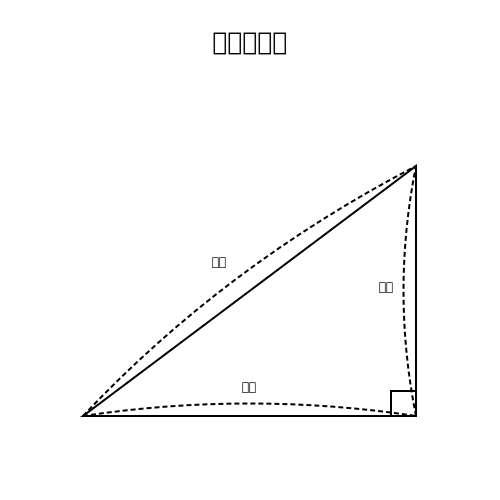

입력된 소단원(section): 직사각형의 특징 알아보기
추출된 개념: 직사각형

생성된 설명:
 ## 직사각형, 특별한 사각형 친구!

안녕하세요! 여러분, 오늘은 우리 주변에서 쉽게 찾아볼 수 있는 특별한 사각형 친구인 **직사각형**에 대해 알아볼 거예요!

**직사각형이란?**

직사각형은 네 개의 변으로 이루어진 사각형 중 **두 쌍의 대변이 평행하고 길이가 같은** 특별한 도형이에요. 마치 튼튼한 직사각형 상자처럼요!

**직사각형의 특징:**

* **대변이 평행:**  직사각형의 긴 변들은 서로 마주보며 평행해요. 마치 옆으로 뻗은 두 개의 직선처럼요!
* **대변 길이 같음:** 직사각형의 긴 변과 짧은 변의 길이는 항상 같아요. 마치 친구끼리 똑같이 나눠주는 것처럼요!
* **네 각은 모두 직각:** 직사각형의 네 각은 모두 90도로 직각이에요. 마치 퍼즐 조각처럼 딱 맞아떨어지는 모양이죠!
* ** 대각선 길이 같음:** 직사각형의 대각선은 길이가 같아요. 마치 두 개의 줄을 연결하는 것처럼요!

직사각형은 우리 일상생활에서 정말 흔하게 볼 수 있어요. 책, 책상, 창문 등 우리 주변 곳곳에 직사각형이 숨어있답니다! 직사각형을 잘 알아보면 세상이 더욱 재미있게 느껴질 거예요!

생성된 코드:
 <svg width="500" height="312" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">직사각형</text>
    <rect x="100" y="100" width="300" height="150" stroke="black" stroke-width="2" fill="none" />
    <!-- 보조선들 -->
    <path d="M 100, 250 Q 250, 220 400, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" /

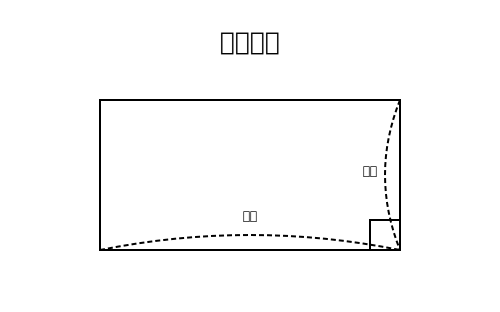

입력된 소단원(section): 정사각형의 특징 알아보기
추출된 개념: 정사각형

생성된 설명:
 정사각형은 특별한 종류의 사각형으로, 모든 변의 길이와 각도가 정확히 같은 특징을 가지고 있어요!

**정의:**

정사각형은 네 개의 변으로 이루어진 도형으로, 각 변의 길이가 모두 같고 네 개의 내각이 모두 직각(90도)인 도형이에요. 마치 정사각형 모양의 퍼즐 조각처럼 모든 부분이 완벽하게 맞아떨어지는 모습이죠!

**특징:**

* **모든 변의 길이가 같아요:**  정사각형의 네 변은 길이가 똑같아서 마치 손가락으로 측정해도 같은 길이를 확인할 수 있어요.
* **모든 내각이 직각이에요:** 정사각형의 네 각은 모두 90도로, 직각삼각형처럼 세 개의 직각이 모여 있어요.
* **대각선이 서로 평행하고 길이가 같아요:** 정사각형 안에서 대각선을 그으면 두 대각선은 서로 평행하며 길이도 같아요. 마치 정사각형을 반으로 자르는 것처럼 생각하면 이해하기 쉬워요!
* **중심에서 각 꼭짓점까지의 거리가 같아요:** 정사각형의 중심에서 네 꼭짓점까지의 거리는 모두 같아요. 이 거리를 **반지름**이라고 부르기도 해요.

정사각형은 우리 주변에서 쉽게 찾아볼 수 있어요! 책, 타일, 창문 프레임 등 다양한 곳에서 정사각형의 아름다움을 느낄 수 있답니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">정사각형</text>
    <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
    <!-- 보조선들 -->
    <path d="M 100, 400 Q 250, 340 400, 400" fill="none" stroke="black" stroke-widt

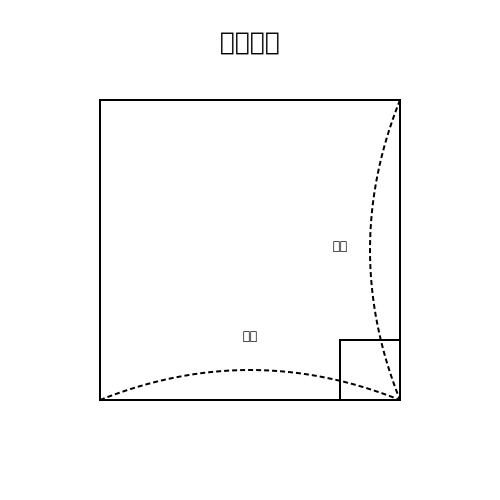

입력된 소단원(section): 원의 반지름과 지름 알아보기
추출된 개념: 원

생성된 설명:
 안녕하세요! 오늘은 원에 대해 재미있게 배워볼게요!

**원의 반지름과 지름**이라는 친구들이 있어요. 이 친구들은 원을 이루는 특별한 친구들이에요.

* **반지름 (Radius):** 원의 중심에서 가장자리까지의 거리예요. 마치 원의 반을 자르면 생기는 선분이 바로 반지름이에요! 쉽게 말해, 원의 가장 바깥쪽 점에서 중심까지의 거리가 반지름이랍니다.

* **지름 (Diameter):** 원의 중심을 지나는 가장 긴 선분이에요. 마치 원을 가로지르는 큰 줄처럼 생각하면 돼요! 지름은 반지름의 두 배 길이예요. 즉, 반지름을 알면 지름은 그 값을 두 배로 늘려주면 돼요!

**예시:**

만약 원의 반지름이 3cm라면, 지름은 3cm × 2 = **6cm**가 되는 거예요!

이렇게 반지름과 지름은 서로 밀접하게 연결되어 있어요. 반지름을 알면 지름을 쉽게 구할 수 있고, 지름을 알면 반지름도 쉽게 찾을 수 있답니다. 원을 보면서 이 친구들을 찾아보세요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


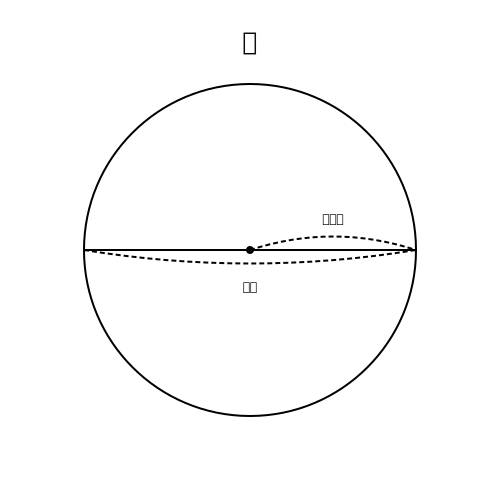

입력된 소단원(section): 지름의 성질 알아보기
추출된 개념: 원

생성된 설명:
 ## 둘레와 지름으로 친구들의 둘레 탐험!

안녕하세요, 친구들! 오늘은 원에 대해 재미있게 알아보는 시간을 가져볼게요!

**1. 지름과 반지름: 원의 친구들**

원은 둥근 모양이죠? 이 둥근 모양을 이루는 중요한 두 친구가 있어요. 하나는 **반지름**이고, 다른 하나는 **지름**이에요.

* **반지름**은 원의 중심에서 **가장자리까지** 뻗어나가는 거리예요. 마치 원 안에 숨어있는 작은 친구처럼요!
* **지름**은 원을 가로지르는 **가장 긴 직선**이에요. 마치 원을 자르는 큰 친구처럼 생각하면 돼요!

**핵심 포인트:** 반지름은 지름의 절반이에요! 마치 친구들 사이의 거리처럼요!

**예시:**

만약 원의 반지름이 5cm라면, 지름은 5cm * 2 = **10cm**가 됩니다.

**2. 둘레 탐험**

원의 **둘레**는 원을 한 바퀴 돌 때 지나가는 거리예요. 마치 원 주위를 걷는 것처럼 생각하면 돼요!

둘레를 구하는 공식은 조금 복잡하지만, 지름을 알면 쉽게 구할 수 있어요. 원의 둘레는 지름에 **π (파이)**를 곱한 값이에요. π는 약 **3.14**로 생각하면 돼요!

**예시:**

지름이 10cm인 원의 둘레는 10cm * 3.14 = **약 31.4cm**가 됩니다.

**3. 비교 탐험**

반지름이나 지름을 알면 둘레를 쉽게 구할 수 있어요! 친구들과 함께 원의 크기를 비교해보는 건 어떨까요?

* 반지름이 같은 두 원 중 하나의 지름이 더 크다면, 둘레도 더 길겠죠?
* 지름이 같은 두 원 중 하나의 반지름이 더 크다면, 둘레도 더 길겠죠?

원의 크기를 비교하며 재미있게 수학을 배우는 거예요!

생성된 공식 raw:
 {'반지름과 지름의 관계': '$\\mathrm{지름} = \\mathrm{반지름} \\times 2$'}


<IPython.core.display.Math object>


생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill="none" />
    <circle cx="250" cy="250" r="3" stroke="black" stroke-width="2" fill="black" />
    <line x1="84" y1="250" x2="416" y2="250" stroke="black" stroke-width="2" />
    <!-- 보조선 -->
    <path d="M 250, 250 Q 333, 223 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="333" y="223" font-size="12" text-anchor="middle">반지름</text>
    <path d="M 84, 250 Q 250, 277 416, 250" fill="none" stroke="black" stroke-width="2" stroke-dasharray="5,3" />
    <text x="250" y="291" font-size="12" text-anchor="middle">지름</text>
    </svg>
    


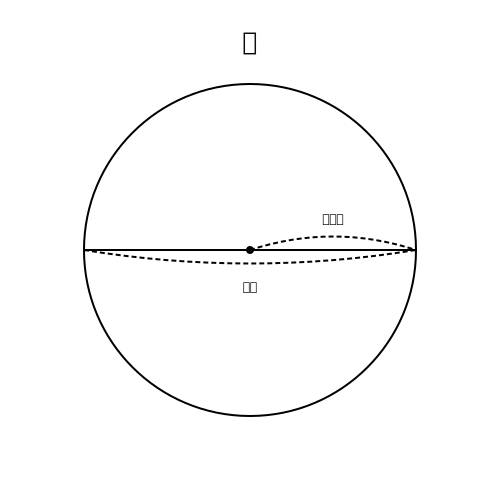

입력된 소단원(section): 원 그리기
추출된 개념: 원

생성된 설명:
 안녕하세요, 친구들! 오늘은 컴퍼스를 이용해 정확한 원을 그리는 방법과 원의 중요한 특징들에 대해 배워볼게요.

### 원 그리기와 반지름/지름 이해하기

**정의:**
원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합입니다. 이 중심점에서 원의 가장자리까지의 거리를 **반지름**이라고 부르고, 원의 지름은 반지름의 두 배입니다. 지름은 원의 가장 긴 직선 거리로, 중심을 지나는 직선입니다.

**기본 성질:**
1. **반지름과 지름의 관계:** 원의 지름은 반지름의 두 배입니다. 예를 들어, 반지름이 3cm인 원의 지름은 6cm가 됩니다.
2. **원주율 (π):** 원의 둘레와 지름 사이의 비율로, 대략 3.14로 사용합니다. 이 값은 원의 크기에 상관없이 일정합니다. 즉, 어떤 크기의 원을 그려도 그 원의 둘레를 지름으로 나눈 값은 항상 약 3.14가 됩니다.
3. **컴퍼스 활용:** 컴퍼스를 사용하면 정확한 반지름 길이를 쉽게 설정할 수 있습니다. 컴퍼스의 한쪽 끝을 원의 중심에 고정하고 다른 끝을 원하는 반지름 길이만큼 떨어뜨려 원을 그릴 수 있습니다. 이렇게 그린 원의 가장자리를 **원주**라고 부르며, 원주는 지름과 π의 곱으로 계산할 수 있습니다 (둘레 = π × 지름).

이렇게 컴퍼스를 이용해 원을 그릴 때마다 반지름과 지름의 개념을 기억하면서 정확성을 높일 수 있어요. 원에 대한 이해가 깊어지면 수학 문제 해결에도 큰 도움이 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">원</text>
    <circle cx="250" cy="250" r="166" stroke="black" stroke-width="2" fill

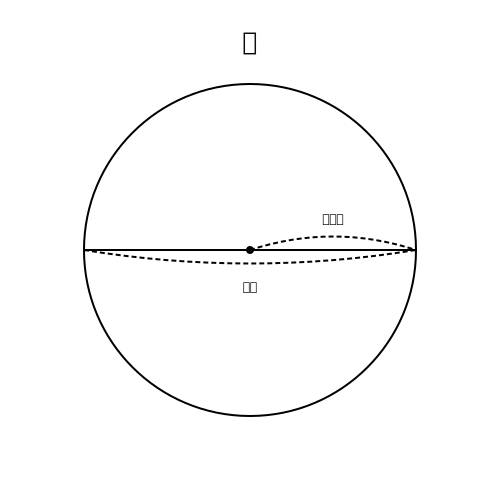

입력된 소단원(section): 원을 이용하여 여러 가지 모양 그리기
추출된 개념: 여러 가지 모양(원)

생성된 설명:
 ## 원을 이용한 멋진 도형 만들기! 🎨💡

우리가 배우는 **원**은 정말 특별한 도형이에요!  

**정의:** 원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합이에요. 마치 중심을 중심으로 춤추는 점들이 모여 아름다운 원을 만드는 것처럼요!

**기본 성질:**

* **둘레와 지름:** 원의 둘레는 지름의 약 **3.14배**입니다. 지름은 원의 가장 긴 직선 거리이고, 둘레는 원의 가장자리 길이를 말해요. 마치 원을 감싸는 끈의 길이를 생각하면 돼요!
* **넓이:** 원의 넓이는 반지름의 제곱에 **3.14**를 곱한 값으로 구할 수 있어요. 넓은 잔디밭처럼 원 안에 들어갈 수 있는 면적을 구하는 거죠!
* **중심각:** 원 위의 두 점을 잇는 선분이 만들어내는 각도를 중심각이라고 해요. 중심각이 클수록 원의 일부분이 더 넓어지는 거예요. 마치 태양이 하늘을 가로지르는 각도처럼요!

**창의적인 활용:**

원의 이러한 특징들을 이용하면 정말 멋진 도형과 패턴을 만들 수 있어요!

* **꽃잎 모양:** 여러 개의 작은 원을 겹쳐서 꽃잎처럼 아름다운 모양을 만들 수 있어요.
* **별 모양:** 여러 개의 원을 연결해서 별 모양을 만들 수도 있죠!
* **패턴 디자인:** 원을 반복해서 배열하면 아름다운 무늬나 그림을 만들 수 있어요. 예를 들어, 원형 타일을 이용해 바닥이나 벽을 장식하는 것처럼요!

원은 단순한 도형이 아니라 창의력을 발휘할 수 있는 멋진 도구랍니다! 🎉

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">여러 가지 모양(원)</text>
    <circle cx="250" cy=

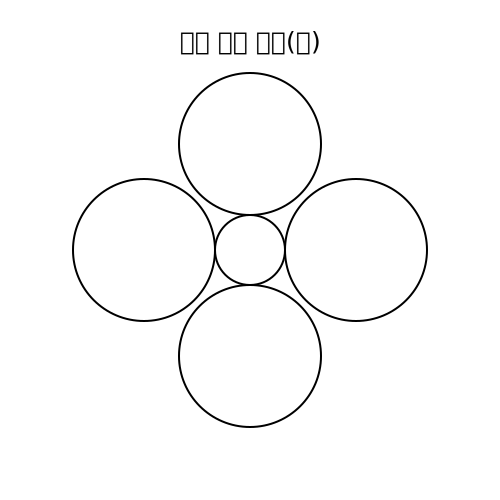

입력된 소단원(section): 각의 크기 비교하기
추출된 개념: 각

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요!

**각도란 무엇일까요?**

각도는 두 직선이 만나서 생기는 공간의 크기를 말해요. 마치 우리가 손을 펴서 만들 수 있는 각도처럼요!

* **직각각**은 90도예요. 마치 직각으로 자른 종이처럼 딱 맞아떨어지는 각도예요. 건물의 모서리나 책상 모서리가 직각각을 이루죠!

* **예각각**은 90도보다 작아요. 예를 들어, 손가락을 살짝 펴서 만든 각도가 예각각에 해당해요. 

* **둔각각**은 90도보다 크고 180도보다 작아요. 마치 팔을 쭉 뻗어서 만든 각도처럼요.  

각도를 비교할 때는 이렇게 생각하면 돼요!

* **직각각 > 둔각각 > 예각각** 순서로 크기가 커져요.

각도를 잘 이해하면 건축이나 그림 그리기 등 일상생활에서도 유용하게 활용할 수 있어요! 궁금한 점이 있으면 언제든지 물어봐요! 😊

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="152.31721787768157" y2="102.87378663688995" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 230.4634435755363,286.974757327378 A 50,50 0 0,1 300,333" stroke="black" stroke-width

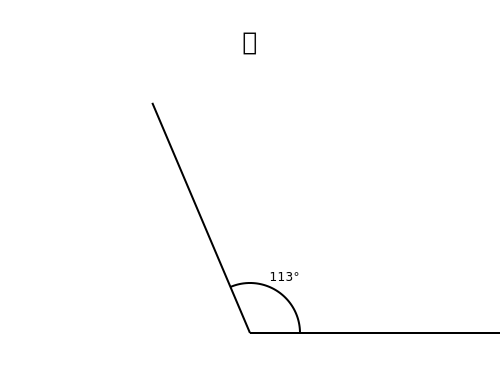

입력된 소단원(section): 각도기를 이용하여 각도 재기
추출된 개념: 각도

생성된 설명:
 안녕하세요! 초등학생 친구들, 각도기를 잘 사용하면 정말 멋진 수학 탐험가가 될 수 있어요!

**각도기**는 마치 마법의 도구 같죠? 🪄

* **정의:** 각도기는 두 직선이 만나서 만드는 **각**의 크기를 측정하는 도구예요. 마치 눈금이 있는 자처럼 보이지만, 각도를 재는 특별한 기능이 있어요!

* **기본 성질:**
    * 각도기는 **직선**을 기준으로 각도를 측정해요. 
    * 각도기의 **중앙선**은 항상 0도를 가리키죠. 
    * 각도는 **시계 방향**으로 측정해요. 예를 들어, 시계 방향으로 45도면 각도기의 눈금이 45도를 가리키게 돼요.

각도기를 잘 활용하면 삼각형이나 사각형처럼 다양한 도형의 각도를 쉽게 알 수 있어요!  수학 탐험을 즐겁게 시작해봐요! 🎉

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="3.0779148512155814" y2="293.8913837399423" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
        <path d="M 200.6155829702431,325.17827674798843 A 50,50 0 0,1 300,333" stroke="black" stroke-width="2" fill="none"/>
        <

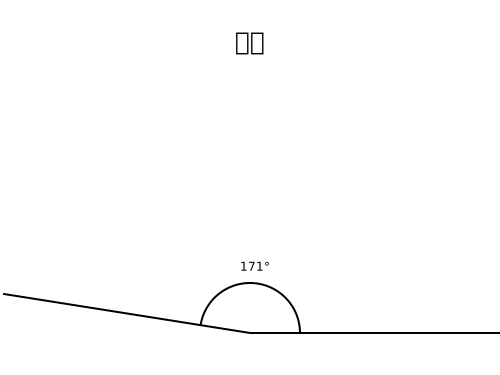

입력된 소단원(section): 각도를 나타내는 단위 알아보기
추출된 개념: 각도

생성된 설명:
 ### 각의 크기와 단위 이해하기

#### 정의:
각은 평면 위에서 두 직선이 만나는 지점을 말하며, 그 크기는 주로 **도(°)** 단위로 표현됩니다. 도는 한 바퀴를 360도로 나눈 단위입니다. 즉, 한 바퀴는 정확히 360°에 해당합니다.

#### 기본 성질:
1. **전체 각도**: 평면 위에서 두 직선이 만나는 각의 합은 항상 **360°**입니다. 예를 들어, 한 직선이 다른 직선과 만나서 만들어지는 각도가 90°라면, 그 직선이 다시 한 바퀴를 돌면서 만나는 각도는 270°가 됩니다 (360° - 90°).

2. **반각**: 어떤 각도의 반은 그 각도를 2로 나눈 값입니다. 예를 들어, 45°의 반각은 **22.5°**입니다. 이는 각도를 쉽게 이해하고 계산하는 데 도움이 됩니다.

3. **직각**: 직각은 정확히 **90°**를 의미합니다. 책상 모서리나 건물의 벽과 바닥이 만나는 부분이 직각의 예입니다.

이러한 개념들을 통해 학생들은 각도를 더 쉽게 이해하고, 다양한 상황에서 각도를 측정하고 계산하는 능력을 키울 수 있습니다. 도 단위를 통해 각도의 크기를 직관적으로 파악하고, 각도의 합과 반각에 대한 기본적인 이해를 바탕으로 더 복잡한 문제 해결에도 접근할 수 있게 됩니다.

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="125" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125" y1="333" x2="2

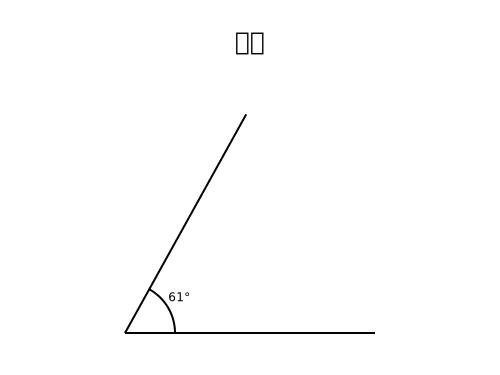

입력된 소단원(section): 각도기와 자를 이용하여 각 그리기
추출된 개념: 각

생성된 설명:
 안녕하세요! 초등학생 친구들! 오늘은 **각도**에 대해 배워볼게요!

**각도란 무엇일까요?**

각도는 두 직선이 만나서 생기는 **공간의 크기**를 나타내는 거예요. 마치 우리가 손을 펴서 만들어 보이는 **"O" 모양**처럼요! 이 "O" 모양의 각 부분을 **각도**라고 부르죠.

**각도 그리기 꿀팁!**

* **각도기**는 각도를 정확하게 측정하는 도구예요. 마치 **자**처럼 길이를 재지만, 각도를 재는 특별한 자랍니다!
* **자**는 직선을 그리거나 길이를 재는 데 쓰죠. 각도를 그릴 때는 **자**를 이용해서 두 직선이 만나는 점을 정확히 표시하면 돼요.

예를 들어, **30도** 각도를 그릴 때는:

1. **자로 직선을 그립니다.**
2. **각도기를 사용해 30도를 표시합니다.** 각도기의 눈금을 따라 30도 위치에 점을 찍어요.
3. **직선이 만나는 점을 표시하면** **30도 각도**가 완성됩니다!

각도를 잘 그리면 그림이나 건축 등 다양한 분야에서 도움이 돼요. 재미있게 연습해보세요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="250" y1="333" x2="117.5201839416988" y2="120.9879759608935" stroke="black" stroke-width="2" />
        <!-- 각도 호 -->
     

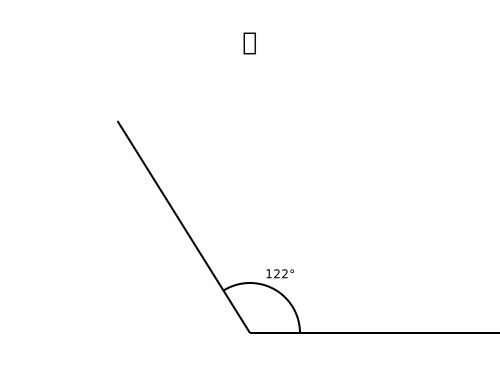

입력된 소단원(section): 예각과 둔각 알아보기
추출된 개념: 예각과 둔각

생성된 설명:
 안녕하세요! 초등학생 친구들, 오늘은 각도에 대해 배워볼게요! 각도는 우리 주변에서 자주 볼 수 있는 모양과 관련이 있어요. 각도를 세 가지 주요 범주로 나누어 이해해볼게요:

1. **예각 (Acute Angle)**
   - **정의**: 예각은 0도보다 크고 90도보다 작은 각도를 말해요. 쉽게 말해, 이 각도는 마치 작은 손이 살짝 펴져 있는 모양 같아요.
   - **기본 성질**: 예각은 항상 양수 값으로 측정되며, 삼각형이나 사각형에서 두 각이 합쳐져 180도를 넘지 않아요. 예를 들어, 두 개의 작은 각이 합쳐져도 여전히 직각보다 작아요.

2. **직각 (Right Angle)**
   - **정의**: 직각은 정확히 90도인 각도예요. 마치 정사각형의 모서리처럼 딱 맞게 직각을 이루는 모양이에요.
   - **기본 성질**: 직각은 특별한 각도 중 하나로, 두 직선이 서로 정확히 만나는 지점에서 만들어져요. 이 각도는 건축이나 그림에서 매우 중요한 역할을 해요. 예를 들어, 책상 모서리나 문 손잡이가 직각을 이루는 경우가 많아요.

3. **둔각 (Obtuse Angle)**
   - **정의**: 둔각은 90도보다 크고 180도보다 작은 각도를 의미해요. 쉽게 말해, 이 각도는 마치 한 손이 약간 더 펴져 있는 모양이에요.
   - **기본 성질**: 둔각은 항상 양수 값이지만, 예각보다 크고 삼각형에서는 한 각이 다른 두 각보다 크면 전체 삼각형의 각도 합이 180도를 초과할 수 있어요. 예를 들어, 큰 각이 있는 삼각형은 직각보다 더 큰 각도를 가질 수 있어요.

이렇게 각도를 이해하면, 우리 주변의 다양한 모양과 구조를 더 잘 파악할 수 있을 거예요! 재미있게 배우셨기를 바라요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text 

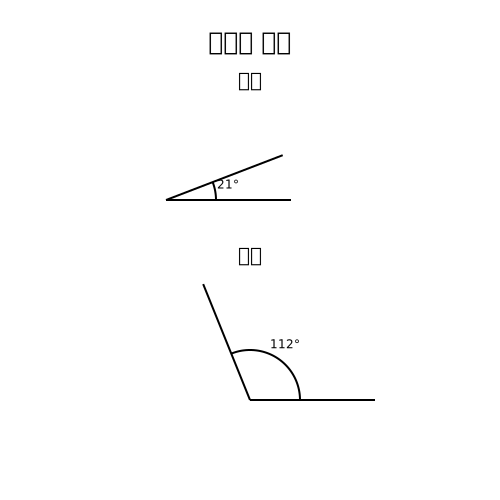

입력된 소단원(section): 각도를 어림하고 각도기로 재어 확인하기
추출된 개념: 각도

생성된 설명:
 ##   각도 맞추기: 우리 주변의 각도 탐험!

안녕하세요, 친구들! 오늘은 우리 주변 세상에서 자주 만나는 **각도**에 대해 알아볼 거예요! 각도는 두 직선이 만나는 지점에서 생기는 **회전**의 크기를 나타내는 거예요. 마치 시계처럼요!

**정의:** 각도는 두 직선이 만나는 지점에서 시작하는 **선분**이 이루는 **공간**의 크기를 말해요. 예를 들어, 시계의 바늘이 한 지점에서 다른 지점으로 이동할 때 그 사이의 각도를 생각해 볼 수 있어요.

**기본 성질:**

* **직선의 각도:** 직선은 0도의 각도를 가지고 있어요. 마치 직선이 움직이지 않는 것처럼요!
* **직각의 각도:** 직각은 90도예요. 마치 퍼즐 조각처럼 딱 맞아떨어지는 각도죠!
* **대칭:** 만약 어떤 도형을 접었을 때 양쪽이 똑같이 보인다면, 그 도형은 각도가 대칭적이라고 할 수 있어요.

**연습 시간!**

* **주변을 살펴보세요:** 책 표지 각도, 문 손잡이 각도, 심지어는 우리 손을 펴서 만든 삼각형 각도까지 모두 각도예요!
* **각도기 활용:** 각도기를 사용해서 직접 각도를 측정해 보세요. 각도기의 눈금을 따라 선을 그려보면서 각도를 어림해 보는 것도 재미있어요!

각도를 배우면서 세상을 더 자세히 관찰하고, 퍼즐처럼 조각들을 맞춰보는 즐거움을 느껴보세요!

생성된 코드:
 <svg width="500" height="375" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">각도</text>
        <!-- 기준선 -->
        <line x1="250" y1="333" x2="500" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 

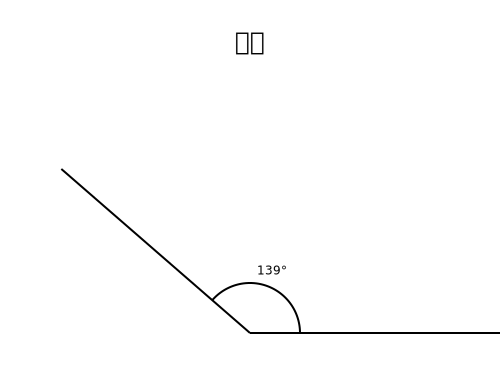

입력된 소단원(section): 각도의 합 또는 차의 활용
추출된 개념: 각도의 합/차

생성된 설명:
 ##  두 각의 크기를 더하고 빼는 마법! 🧙‍♀️🧙‍♂️

안녕하세요, 친구들! 오늘은 **각도 마법**을 배워볼 거예요! 

**1. 정의:**

각도 마법은 마치 퍼즐 조각처럼, 두 개의 각을 더하거나 빼서 새로운 각을 찾는 재미있는 방법이에요. 마치 각도를 탐험하는 모험처럼 신나죠!

**2. 기본 성질:**

* **더하기 마법:** 두 각의 크기를 더하면, 그 두 각이 이루는 **큰 각**을 구할 수 있어요. 마치 두 개의 작은 퍼즐 조각을 합쳐서 더 큰 그림을 만드는 것처럼요!

* **빼기 마법:** 한 각에서 다른 각을 빼면, **남은 각**을 구할 수 있어요. 마치 퍼즐 조각 중 하나를 빼서 다른 조각들을 더 잘 맞추는 것처럼요!

**예시:**

* **더하기 마법:**  30도 각과 45도 각을 더하면 75도가 됩니다. 🎉
* **빼기 마법:** 90도 각에서 45도 각을 빼면 45도가 남습니다. 🤔

각도 마법을 통해 우리는 세상 곳곳에서 각도를 이해하고 활용할 수 있어요!  

**연습해 볼까요?** 친구들과 함께 각도 퍼즐을 만들어 보세요! 😊

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 차 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 재미있게 배워볼게요!

**큰 각에서 작은 각을 빼는 것**이란 마치 퍼즐 조각을 맞추는 것 같아요. 큰 그림(큰 각) 안에서 작은 조각(작은 각)을 찾아내는 거죠!

예를 들어, 시계를 생각해 보세요. 12시에서 시작해서 3시까지는 90도의 각도를 차지해요. 그런데 만약 3시에서 다시 6시까지의 각도를 알고 싶다면, 90도에서 180도를 빼면 돼요. 이렇게 하면 90도에서 180도 사이에 있는 각도, 즉 90도가 남게 되죠!

**핵심은:**

* **큰 각에서 작은 각을 빼면** 그 사이의 각도가 남게 돼요.
* 각도는 시계 방향이나 반시계 방향으로 측정할 수 있어요. 중요한 건 **방향**이 아니라 **크기**를 비교하는 거예요!

이렇게 각도를 이해하면, 그림 그리기나 건축 등 다양한 분야에서 유용하게 활용할 수 있어요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 두 각도의 합 구하기
추출된 개념: 각도의 합/차

생성된 설명:
 안녕하세요! 오늘은 각도에 대해 배워볼게요. 특히 두 각도를 더했을 때 어떤 결과가 나오는지 알아볼게요.

### 각도 더하기

**정의:**
각도 더하기는 두 개 이상의 각도를 합쳐서 하나의 더 큰 각도를 만드는 것을 의미해요. 예를 들어, 45°와 60°라는 두 각도를 더하면 그 결과는 105°가 됩니다.

**기본 성질:**
1. **순서 무관성:** 각도를 더할 때는 각도의 크기 순서에 상관없이 더할 수 있어요. 예를 들어, 60°와 45°를 더하는 것은 45°와 60°를 더하는 것과 결과는 동일해요. 즉, 각도의 순서를 바꾸어도 합은 변하지 않아요.
   
2. **합의 범위:** 각도를 더할 때는 항상 360°를 넘지 않아야 해요. 만약 더하면 360°를 초과하면, 그 초과 부분은 다시 0°로 돌아가서 계산해요. 예를 들어, 30°와 370°를 더하면 실제 합은 360°가 되고, 초과한 10°는 무시됩니다.

이렇게 각도를 더함으로써 다양한 도형의 크기나 방향을 이해하는 데 도움이 돼요. 각도 더하기는 일상생활에서도 자주 활용되니, 연습을 통해 익숙해지면 좋을 것 같아요!

생성된 공식 raw:
 {'두 각도의 합': '$\\mathrm{두 \\;각도의 \\;합}: \\mathrm{한 \\;각의 \\;크기(°)} + \\mathrm{다른 \\;각의 \\;크기(°)}$', '두 각도의 차': '$\\mathrm{두 \\;각도의 \\;차}: \\mathrm{큰 \\;각의 \\;크기(°)} - \\mathrm{작은 \\;각의 \\;크기(°)}$'}


<IPython.core.display.Math object>

<IPython.core.display.Math object>

입력된 소단원(section): 삼각형에서 나머지 한 각의 크기 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 안녕하세요! 오늘은 삼각형의 특별한 성질에 대해 배워볼게요. 특히, 삼각형의 세 각이 항상 180°를 더한다는 사실을 이용해 나머지 한 각의 크기를 찾는 방법에 대해 알아볼게요.

### 삼각형의 기본 성질

**정의:**
삼각형은 세 개의 변과 세 개의 각으로 이루어진 도형입니다. 가장 중요한 성질 중 하나는 **삼각형의 내각의 합이 항상 180°**라는 것입니다. 이는 어떤 종류의 삼각형이든 (예: 직각삼각형, 예각삼각형, 둔각삼각형) 적용되는 기본적인 규칙입니다.

**기본 성질:**
1. **내각의 합:** 삼각형의 세 각의 합은 항상 180°입니다. 이는 삼각형의 기본적인 기하학적 성질로, 삼각형을 그릴 때 항상 기억해야 할 중요한 규칙입니다.
   
2. **각의 계산 방법:** 만약 삼각형에서 두 각의 크기가 이미 알려져 있다면, 나머지 한 각의 크기를 쉽게 구할 수 있습니다. 예를 들어, 두 각의 크기가 각각 \(A\)와 \(B\)라고 가정해봅시다. 이때 나머지 한 각 \(C\)의 크기는 다음과 같이 계산할 수 있습니다:
   \[
   C = 180° - (A + B)
   \]
   즉, \(A\)와 \(B\)의 합을 180°에서 빼면 나머지 각 \(C\)의 크기를 알 수 있습니다.

이렇게 삼각형의 기본 성질을 활용하면, 주어진 정보만으로도 삼각형 내 각의 크기를 쉽게 파악할 수 있어요. 연습을 통해 이런 계산 능력을 키워나가면 수학이 더욱 재미있어질 거예요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 세 각의 크기의 합 구하기
추출된 개념: 삼각형의 내각의 합

생성된 설명:
 안녕하세요! 오늘은 삼각형의 특별한 성질에 대해 배워볼게요. 특히, 삼각형의 세 각의 크기가 어떻게 합쳐지는지 알아보는 거예요.

### 삼각형의 내각의 합

**정의:**
삼각형은 세 개의 변과 세 개의 각으로 이루어진 도형이에요. 우리가 오늘 살펴볼 핵심 개념은 바로 **삼각형의 내각의 합**이에요. 이는 삼각형 내부에 있는 세 개의 각의 크기를 모두 더한 값이에요.

**기본 성질:**
1. **합의 크기:** 삼각형의 세 각의 크기를 모두 더하면 항상 **180°**가 됩니다. 이건 어떤 종류의 삼각형이든 상관없이 항상 성립하는 규칙이에요. 예를 들어, 직각삼각형(각이 90°인 삼각형), 예각삼각형(모든 각이 90° 미만인 삼각형), 둔각삼각형(한 각이 90° 초과인 삼각형) 모두 포함해서요.
   
2. **각의 크기 예시:** 만약 삼각형의 세 각이 각각 60°, 70°, 그리고 50°라면, 이들을 더하면 \(60° + 70° + 50° = 180°\)가 되어 삼각형의 내각의 합이 정확히 180°임을 확인할 수 있어요.

이렇게 삼각형의 내각 합이 항상 180°라는 사실을 알게 되면, 삼각형의 각을 측정하거나 삼각형의 종류를 판단하는 데 큰 도움이 될 거예요. 재미있게 삼각형의 비밀을 파헤치는 시간이 되길 바라요!

생성된 공식 raw:
 {'삼각형의 내각의 합': '$\\mathrm{삼각형의 \\;내각의 \\;합} = 180°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 나머지 한 각의 크기 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 안녕하세요! 오늘은 사각형의 특별한 성질에 대해 배워볼게요. 특히, 사각형의 네 각이 항상 합쳐져서 360°라는 재미있는 사실을 알아볼게요!

### 사각형의 각 성질

**정의:**
사각형은 네 개의 변과 네 개의 꼭지점을 가진 도형이에요. 가장 중요한 특징 중 하나는 모든 내각의 합이 항상 360°라는 거예요. 이건 마치 사각형을 여러 작은 삼각형으로 나눌 수 있다는 뜻이에요!

**기본 성질:**
1. **내각의 합:** 사각형의 네 각을 모두 더하면 항상 360°가 됩니다. 예를 들어, 만약 사각형의 세 각의 크기가 각각 120°, 100°, 그리고 110°라면, 나머지 한 각의 크기를 쉽게 구할 수 있어요.
   
2. **나머지 각 구하기:**
   - **공식 대신 방법:** 사각형의 네 각의 합이 항상 360°라는 걸 기억하면 돼요. 세 각의 크기를 알면, 그 합에서 360°를 빼면 나머지 한 각의 크기를 바로 알 수 있어요.
   - **예시 계산:** 만약 세 각의 크기가 120°, 100°, 그리고 110°라면,
     \[
     120° + 100° + 110° = 330°
     \]
     따라서 나머지 한 각의 크기는
     \[
     360° - 330° = 30°
     \]
     즉, 나머지 한 각의 크기는 **30°**가 됩니다.

이렇게 사각형의 각 성질을 이용하면, 주어진 세 각의 크기만 알면 나머지 한 각의 크기를 쉽게 구할 수 있어요! 재미있죠?

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 사각형의 네 각의 크기의 합 구하기
추출된 개념: 사각형의 내각의 합

생성된 설명:
 안녕하요! 오늘은 사각형의 특별한 성질에 대해 배워볼게요!

**사각형의 내각 합**이라는 건 쉽게 말해, 사각형 네 개의 모서리 각도를 모두 더하면 항상 **360°**가 된다는 거예요. 마치 네 개의 작은 퍼즐 조각을 맞추듯이, 각 조각의 각도를 합치면 큰 그림이 완성되는 거죠!

**예를 들어:**

* 만약 한 사각형의 각이 각각 90°, 100°, 110°, 70°라면,
* 90° + 100° + 110° + 70° = **360°**가 되는 거예요!

이렇게 사각형의 각도 합이 항상 360°라는 건 정말 신기하죠?  사각형을 그려보면서 직접 각도를 측정해보면서 확인해보는 건 어떨까요? 😊

생성된 공식 raw:
 {'사각형의 내각의 합': '$\\mathrm{사각형의 \\;내각의 \\;합} = 360°$'}


<IPython.core.display.Math object>

입력된 소단원(section): 삼각형의 변의 길이에 따라 분류하기
추출된 개념: 삼각형 분류(변)

생성된 설명:
 안녕하세요! 오늘은 삼각형의 세 가지 주요 종류에 대해 배워볼게요. 각각의 특징을 쉽게 이해할 수 있도록 설명해드릴게요.

### 1. 일반삼각형 (예각삼각형)
- **정의**: 일반삼각형은 세 변의 길이가 모두 다른 삼각형을 말해요. 즉, 가장 긴 변과 그에 대응하는 가장 긴 각도가 예각(90도보다 작은 각도)인 삼각형이에요.
- **기본 성질**:
  - 세 변의 길이가 모두 다르다.
  - 가장 긴 변은 가장 큰 각도와 마주보는 변이다.
  - 예각삼각형의 경우, 가장 긴 변의 길이는 다른 두 변의 길이의 합보다 작다.

### 2. 이등변삼각형
- **정의**: 이등변삼각형은 두 변의 길이가 같은 삼각형이에요. 이 두 같은 길이의 변을 **등변**이라고 부르며, 이에 대응하는 각도도 같아요.
- **기본 성질**:
  - 두 변의 길이가 같다.
  - 이등변삼각형의 높이는 그 등변을 기준으로 대칭이 되는 위치에 있으며, 이 높이는 등변을 이등분한다.
  - 세 번째 변은 항상 이등변삼각형의 다른 두 변보다 짧다.

### 3. 정삼각형
- **정의**: 정삼각형은 세 변의 길이가 모두 같고 세 각도도 모두 같은 크기인 삼각형이에요. 모든 내각은 정확히 60도예요.
- **기본 성질**:
  - 세 변의 길이가 모두 동일하다.
  - 세 각의 크기는 모두 60도이다.
  - 정삼각형의 높이는 한 변을 기준으로 그 변을 이등분하며, 이 높이는 또한 삼각형을 두 개의 동일한 직각삼각형으로 나눈다.

이렇게 세 가지 형태의 삼각형은 각각 다른 특징을 가지고 있어, 다양한 문제 해결과 기하학적 이해에 도움이 됩니다. 이해하셨나요? 궁금한 점이 있으면 언제든지 물어봐 주세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="

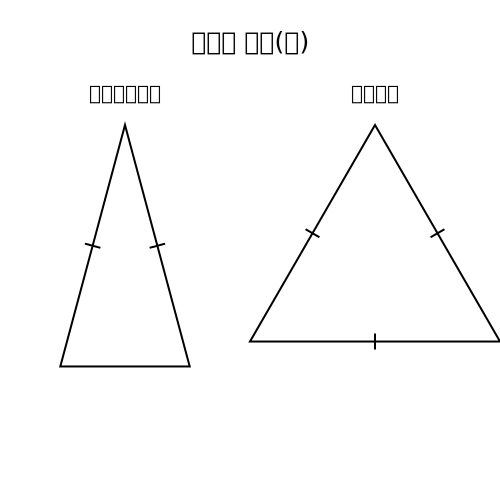

입력된 소단원(section): 이등변삼각형 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 ### 이등변삼각형 이해하기

**정의:**
이등변삼각형은 삼각형의 세 변 중에서 정확히 두 변의 길이가 같은 특별한 종류의 삼각형입니다. 이 두 같은 길이의 변을 **밑변**이라고 부르며, 나머지 한 변을 **높이**라고 부릅니다. 이등변삼각형의 특징 중 하나는 밑변을 기준으로 양쪽으로 대칭이 되는 두 각도가 같다는 것입니다.

**기본 성질:**
1. **밑변과 높이의 관계:** 이등변삼각형의 밑변을 기준으로 그 위에 높이를 그으면, 이 높이는 밑변을 정확히 반으로 나눕니다. 즉, 높이가 밑변을 두 개의 동일한 길이의 선분으로 나누게 됩니다.
   
2. **대칭성:** 밑변을 기준으로 양쪽이 완전히 대칭입니다. 따라서 밑변을 중심으로 돌리면 삼각형이 완전히 일치하게 됩니다.

3. **각도의 특성:** 밑변에 대응하는 두 각도는 같고, 나머지 한 각도는 이 두 각도의 합보다 작아집니다. 예를 들어, 밑변에 대응하는 두 각도가 각각 \( \theta \)라면, 나머지 각도는 \( 180^\circ - 2\theta \)가 됩니다.

이러한 성질들 덕분에 이등변삼각형은 다양한 기하학적 문제 해결에 유용하게 사용됩니다. 학생들이 이등변삼각형의 특징을 이해하면, 삼각형의 각도와 변의 관계를 더 잘 파악할 수 있게 됩니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-w

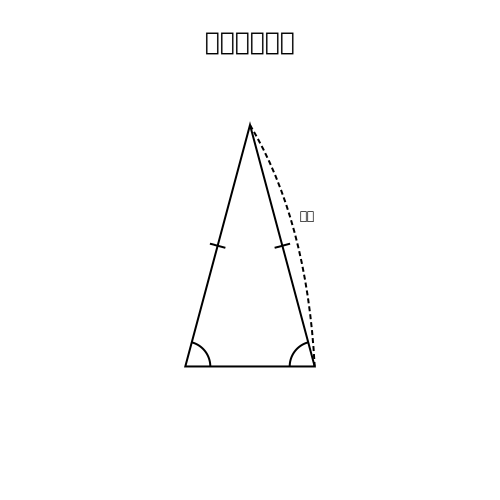

입력된 소단원(section): 이등변삼각형의 성질 알아보기
추출된 개념: 이등변삼각형

생성된 설명:
 ##  🌈  이등변 삼각형 친구들! 🌈

안녕하세요! 오늘은 특별한 삼각형 친구, **이등변 삼각형**에 대해 알아볼 거예요!

**정의:** 이등변 삼각형은 세 변 중 **두 변의 길이가 같은** 삼각형이에요. 마치 친구들이 양쪽 팔을 똑같이 뻗어있는 모습처럼요!

**기본 성질:**

* **밑변의 중점:** 이등변 삼각형에서 밑변을 반으로 나누는 선은 **빗변과 평행**하게 그려져요. 마치 밑변을 자르는 마법 같죠!
* **대변의 길이:** 밑변에 마주보는 두 변의 길이는 **같아요**. 마치 친구들이 서로 손을 잡고 있는 것처럼요!
* **대칭축:** 밑변을 기준으로 양쪽이 똑같이 mirrored 되는 선을 **대칭축**이라고 해요. 이 선을 그리면 삼각형을 반으로 접어도 똑같이 보이게 돼요!

이등변 삼각형은 특별한 성질 덕분에 다양한 문제를 풀 때 유용하게 쓰일 수 있어요. 예를 들어, 삼각형의 높이를 구하거나 넓이를 계산할 때 도움이 될 거예요! 

**기억하세요!** 이등변 삼각형 친구들은 항상 두 변의 길이가 같아서 특별한 친구랍니다! 🎉

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <path d="M 250, 125 Q 307.0, 220.0 31

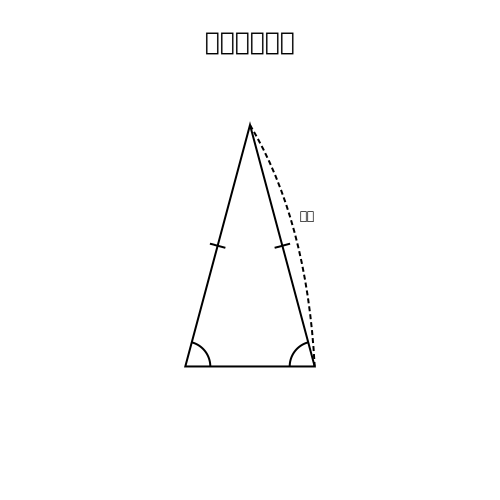

입력된 소단원(section): 각을 이용하여 이등변삼각형 그리기
추출된 개념: 이등변삼각형

생성된 설명:
 안녕하세요! 오늘은 **이등변삼각형**에 대해 배워볼게요!

**정의:** 이등변삼각형은 삼각형의 세 변 중 **두 변의 길이가 같은** 특별한 삼각형이에요. 마치 두 다리가 같은 길이인 삼각형처럼요!

**기본 성질:**

* **밑변:** 이등변삼각형에서 두 변의 길이가 같은 변을 밑변이라 부르죠. 밑변을 기준으로 양쪽에 있는 두 변은 **높이**가 되어 서로 수직으로 만나요. 마치 삼각형 지붕처럼요!
* **높이:** 밑변을 이등분하는 선분으로, 밑변과 만나는 점을 **꼭짓점**이라고 해요. 이 높이는 삼각형을 두 개의 **직각삼각형**으로 나누어 주어요.

이등변삼각형은 모양이 다양하지만, 기본적으로 두 변의 길이가 같다는 특징이 중요해요! 이 특징 덕분에 여러 가지 재미있는 성질들을 가지고 있답니다. 예를 들어, 높이를 이용해서 면적을 쉽게 구할 수도 있어요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">이등변삼각형</text>
        <!-- 아등변삼각형 -->
        <polygon points="250,125 314.7047612756302,366.4814565722671 185.29523872436982,366.4814565722671" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <path d="M 250, 125 Q 307.0, 220.0 314.7047612756302, 366.4814565722671" fill="none" stroke="black"
        stroke-width="2" stroke-dasharra

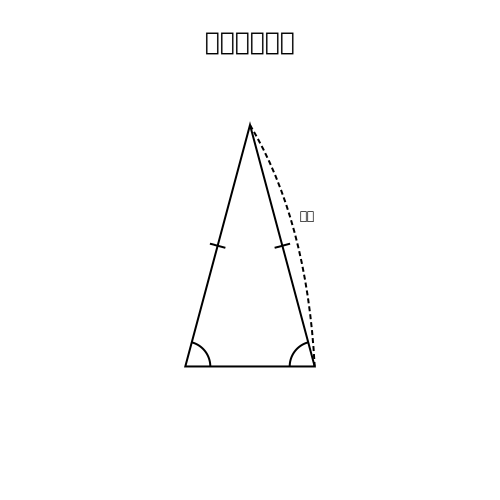

입력된 소단원(section): 정삼각형의 성질 알아보기
추출된 개념: 정삼각형

생성된 설명:
 정삼각형은 모든 변의 길이가 같고, 모든 내각의 크기가 같은 특별한 삼각형입니다. 초등학생들이 이해하기 쉽게 설명해보겠습니다.

### 정의
정삼각형은 **세 변의 길이가 모두 같고 세 각의 크기가 모두 같은 삼각형**입니다. 이 삼각형은 가장 균형 잡힌 모양 중 하나로, 모든 부분이 완벽하게 대칭적입니다.

### 기본 성질
1. **모든 내각의 크기**: 정삼각형의 세 각은 모두 **60도**입니다. 즉, 삼각형의 내각의 합이 항상 180도라는 기본 원리에 따라, 각 내각이 정확히 반으로 나누어져 60도가 됩니다.
   
2. **모든 변의 길이**: 정삼각형의 세 변은 **모두 같은 길이**를 가지고 있습니다. 이 길이를 **변의 길이**라고 부르며, 이 길이는 삼각형을 그릴 때 쉽게 측정할 수 있습니다.

3. **높이와 중선**: 정삼각형의 높이는 한 변을 이등분하는 선분으로, 이 높이는 또한 그 변의 중점에서 대변의 중점까지의 거리와 같습니다. 이 높이는 삼각형을 두 개의 동일한 직각삼각형으로 나누어 줍니다. 각 직각삼각형의 빗변은 정삼각형의 변의 길이와 같고, 밑변은 변의 절반입니다.

### 활용 예시
- **건축 및 디자인**: 정삼각형의 대칭성과 균형 잡힌 모양은 건물의 지붕이나 장식 요소로 활용될 수 있습니다. 예를 들어, 정삼각형 모양의 창문이나 패턴은 시각적으로 안정감을 줍니다.
- **게임 및 퍼즐**: 정삼각형의 대칭성은 퍼즐 조각 맞추기나 게임에서 균형 잡힌 배치를 만드는 데 유용합니다. 예를 들어, 정삼각형 모양의 블록을 이용해 구조물을 만들 때 안정적인 구조를 만들 수 있습니다.

이러한 성질들 덕분에 정삼각형은 수학적 이해뿐 아니라 창의적인 활동에서도 흥미로운 역할을 합니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <te

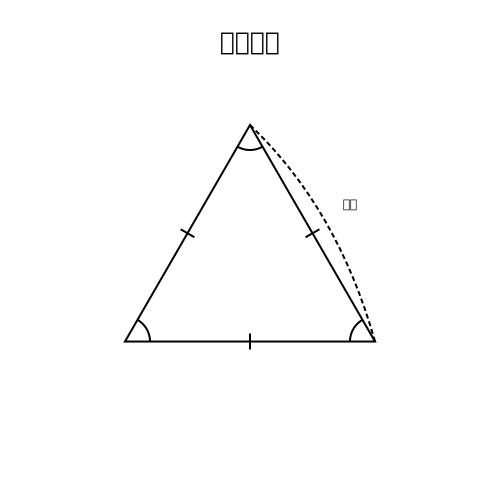

입력된 소단원(section): 정삼각형 알아보기
추출된 개념: 정삼각형

생성된 설명:
 ### 정삼각형 이해하기

**정의:**
정삼각형은 세 변의 길이가 모두 같은 특별한 종류의 삼각형입니다. 이 세 변의 길이를 각각 \(a\)라고 부르며, 모든 변의 길이가 정확히 같다는 특징이 있습니다. 또한, 세 각의 크기도 모두 같아서 각각 \(60^\circ\)가 됩니다.

**기본 성질:**
1. **변의 길이 동일:** 정삼각형의 가장 중요한 특징 중 하나는 세 변의 길이가 모두 같다는 것입니다. 예를 들어, 변의 길이가 \(a\)인 정삼각형에서는 모든 변의 길이가 \(a\)입니다.
   
2. **각의 크기 동일:** 정삼각형은 세 각이 모두 같으며, 각각의 크기는 \(60^\circ\)입니다. 이는 삼각형의 내각의 합이 항상 \(180^\circ\)라는 사실을 이용해 쉽게 알 수 있습니다: \(60^\circ + 60^\circ + 60^\circ = 180^\circ\).

3. **높이와 중선의 관계:** 정삼각형의 높이는 한 변을 이등분하는 선분과 만나는 점에서 직각삼각형을 형성합니다. 이 직각삼각형의 빗변은 변의 길이 \(a\)이고, 밑변은 \(a/2\)입니다. 피타고라스 정리에 따르면, 높이 \(h\)는 \(h = \sqrt{a^2 - (a/2)^2} = \sqrt{3a^2/4} = \frac{\sqrt{3}}{2}a\)가 됩니다. 이는 정삼각형의 높이가 변의 길이의 \(\sqrt{3}\)배임을 보여줍니다.

이러한 성질들 덕분에 정삼각형은 기하학에서 매우 중요한 역할을 하며, 다양한 도형과 문제 해결에 활용됩니다. 학생들이 이러한 개념을 이해하면, 삼각형의 기본 구조와 성질을 더 잘 파악할 수 있게 됩니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="mi

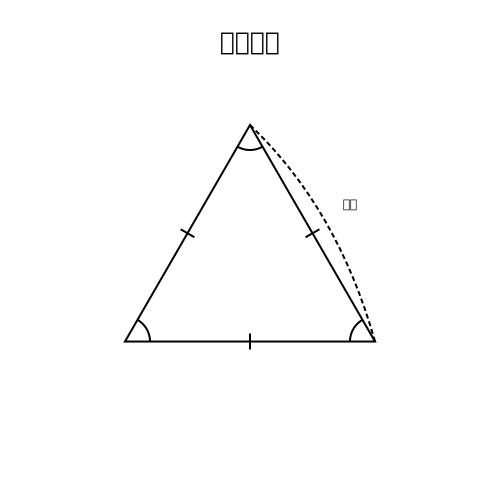

입력된 소단원(section): 각을 이용하여 정삼각형 그리기
추출된 개념: 정삼각형

생성된 설명:
 안녕하요! 오늘은 재미있는 기하학 이야기를 해볼게요!

**정삼각형 만들기**

상상해봐요! 선분 하나를 가지고 있어요. 이 선분의 양쪽 끝에서 각각 60°씩 꺾어서 새로운 선분을 그려보세요. 이렇게 하면 선분이 세 개로 나뉘어지면서 **정삼각형**이 완성되는 거예요!

**정삼각형이란?**

* **정의:** 정삼각형은 세 변의 길이가 모두 같고, 세 각도도 모두 60°인 특별한 삼각형이에요. 마치 세 개의 뾰족한 별처럼 생겼어요!

* **기본 성질:**
    * **세 변의 길이가 같다:**  모두 같은 길이를 가지고 있어요. 마치 친구들이 모두 같은 옷을 입은 것처럼요!
    * **세 각도가 같다:** 각각 60°로 똑같아요. 마치 세 친구가 같은 방향을 바라보는 것처럼요!
    * **내각의 합은 항상 180°:** 삼각형의 모든 각도를 합치면 항상 180°가 되는 거예요. 마치 세 친구가 모여 앉았을 때의 총 각도가 항상 180°인 것처럼요!

정삼각형은 정말 멋지죠? 세 변과 세 각도가 모두 똑같아서 특별한 모양을 만들어낸답니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정삼각형</text>
        <!-- 정삼각형 -->
        <polygon points="250,125 375.0,341.50635094610965 125.00000000000006,341.5063509461097" stroke="black" stroke-width="2" fill="none"/>
        <!-- 보조선들 -->
        <path d="M 250, 125 Q 337.5, 208.25317547305482 375.0, 3

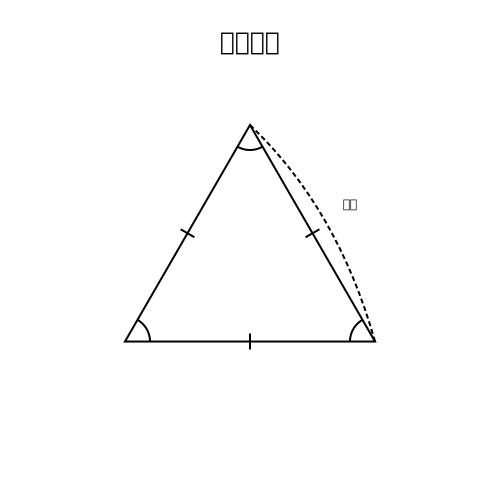

입력된 소단원(section): 예각삼각형 알아보기
추출된 개념: 예각삼각형

생성된 설명:
 ## 세 각이 모두 예각인 삼각형, 바로 **예각삼각형**이야! 🎉

**정의:** 예각삼각형은 삼각형의 세 각 모두가 **90도보다 작은 예각**인 삼각형을 말해요. 마치 햇살처럼 밝고 경쾌한 느낌을 주는 삼각형이죠!

**특징:**

* **모든 각이 예각:**  가장 중요한 특징은 세 각 모두가 뾰족하게 솟아있어 예각이라는 거예요. 마치 웃는 얼굴처럼요!
* **가장 긴 변은 가장 짧은 변에 비해 짧다:** 예각삼각형에서 가장 긴 변은 가장 짧은 변보다 짧답니다. 마치 긴 다리가 짧은 다리를 지탱하는 것처럼요!
* **빗변의 길이는 가장 짧은 변의 길이의 √3배보다 짧다:**  빗변은 삼각형의 가장 긴 변이고, 가장 짧은 변과의 관계에서 특별한 규칙이 있어요. 이 규칙을 기억하면 삼각형을 쉽게 판별할 수 있어요!

예각삼각형은 정말 멋지죠? ☀️  각이 뾰족해서 더욱 밝고 활기찬 느낌을 주는 삼각형이랍니다! 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">예각삼각형</text>
        <polygon points="166,125 100,400 400,400" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


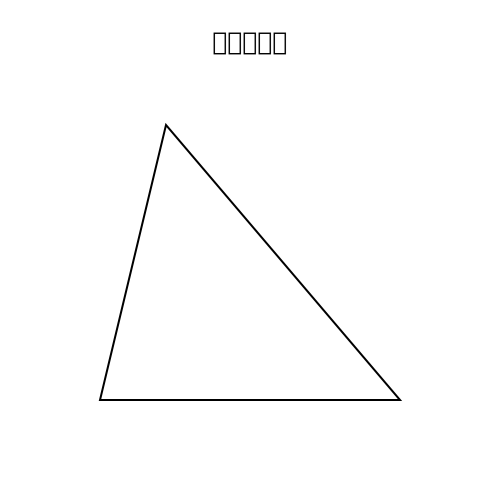

입력된 소단원(section): 삼각형을 각의 크기에 따라 분류하기
추출된 개념: 삼각형 분류(각)

생성된 설명:
 안녕하세요! 오늘은 삼각형의 세 가지 주요 종류인 예각삼각형, 직각삼각형, 둔각삼각형에 대해 배워볼게요!

**1. 예각삼각형**

* **정의:** 모든 각이 **90도보다 작은** 삼각형이예요. 마치 햇살처럼 밝고 경쾌한 느낌을 주죠!
* **기본 성질:** 세 변의 길이가 모두 다르고, 가장 긴 변은 가장 큰 각에 대응해요.

**2. 직각삼각형**

* **정의:** 한 각이 정확히 **90도**인 삼각형이에요. 마치 직각으로 꺾이는 도로처럼 정확하고 안정적인 모양이죠!
* **기본 성질:** 가장 긴 변을 **빗변**이라고 부르는데, 이 빗변은 다른 두 변과 직각을 이루어요. 피타고라스 정리(빗변2 = 다른 두 변의 제곱의 합)를 이용하면 쉽게 빗변의 길이를 구할 수 있어요.

**3. 둔각삼각형**

* **정의:** 한 각이 **90도보다 큰** 삼각형이에요. 마치 햇살이 조금 덜 밝은 날처럼 조금 더 여유로운 느낌을 줘요.
* **기본 성질:** 가장 긴 변은 가장 큰 각에 대응하고, 가장 긴 변의 길이가 다른 두 변의 길이 합보다 길어요.

이렇게 삼각형은 각의 크기에 따라 다양한 모양을 가지고 있어요. 각 모양을 잘 알아보면 삼각형에 대한 이해가 훨씬 깊어질 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
    <text x="250" y="50" font-size="25" text-anchor="middle">삼각형 분류(각)</text>
    <!-- 예각삼각형 -->
    <text x="83" y="100" font-size="20" text-anchor="middle">예각삼각형</text>
    <polygon points="83,125 50,400 150,400" stroke="black" stroke-width

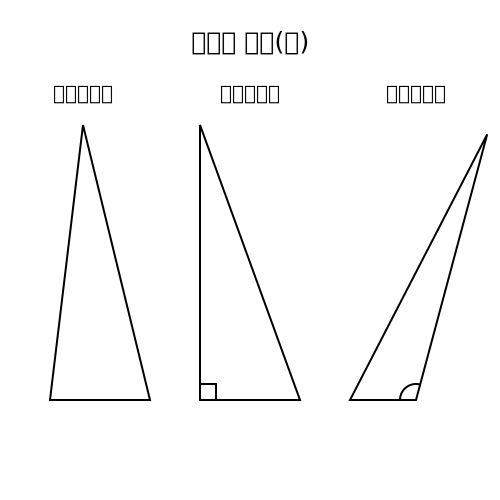

입력된 소단원(section): 둔각삼각형 알아보기
추출된 개념: 둔각삼각형

생성된 설명:
 안녕하세요! 오늘은 **둔각삼각형**에 대해 알아볼게요!

**정의:**

둔각삼각형은 삼각형의 한 각이 **90도보다 큰** 삼각형을 말해요. 쉽게 말해, 삼각형 안에 **둔각**이 하나 있다는 거죠!

**특징:**

* **가장 긴 변:** 둔각삼각형에서는 가장 긴 변은 **둔각의 반대쪽**에 위치해 있어요. 마치 삼각형이 살짝 기울어져 있는 것처럼 느껴지죠?
* **면적:** 둔각삼각형의 면적은 다른 종류의 삼각형보다 조금 작아요. 왜냐하면 둔각이 커질수록 삼각형이 좁아지기 때문이에요.
* **높이:** 둔각삼각형에서는 둔각을 이루는 변에 내린 **높이**가 가장 길어요. 마치 삼각형을 평평하게 펴서 그 높이를 측정하면 가장 긴 변이 될 거예요!

**예시:**

삼각형 ABC에서 ∠A가 120도라면, 이 삼각형은 둔각삼각형이에요. 왜냐하면 ∠A가 90도보다 크기 때문이죠!

둔각삼각형을 잘 살펴보면서 특징들을 찾아보세요! 재미있게 배우는 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">둔각삼각형</text>
        <polygon points="375,125 100,400 300,400" stroke="black" stroke-width="2" fill="none"/>
        <path d="M 284,400 A 16,16 0 0,1 304.20987849267374,384.5637788601963" stroke="black" stroke-width="2" fill="none"/>
        </svg>
        


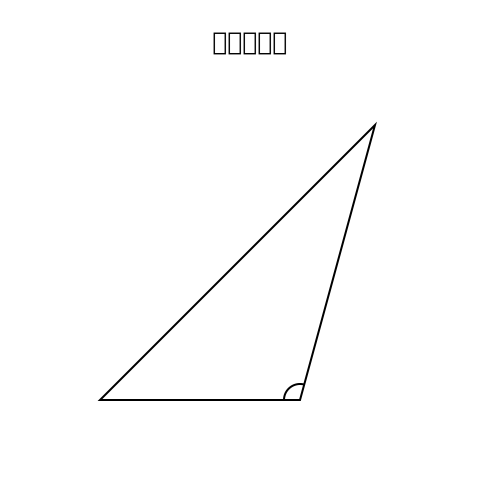

입력된 소단원(section): 삼각자와 각도기를 이용한 수선 긋기
추출된 개념: 수선

생성된 설명:
 ##  점에서 직선에 수선 그리기:  💡 핵심 개념! 💡

안녕하세요! 초등학생 친구들! 오늘은 재미있는 기하학 탐험을 해볼게요!

**1. 정의:**

점에서 직선에 수선을 그리는 건 마치 **직선 위에 있는 친구를 정확히 만나는 선**을 그리는 것과 같아요!  

상상해봐요. 친구가 줄 위에 서 있는데, 우리가 그 친구를 정확히 만나는 지점을 찾고 싶다면, 줄에 수직으로 선을 그어 그 친구를 만나게 할 수 있겠죠? 그처럼 특정 점에서 주어진 직선에 수직으로 선을 그어 그 직선과 만나는 점을 찾는 거예요!

**2. 기본 성질:**

* **수직선의 각도:** 점에서 그린 수선은 주어진 직선과 **90도**의 각을 이룹니다. 마치 친구를 만나는 선이 친구와 딱 수직으로 만나는 것처럼요!
* **거리 유지:** 점에서 그린 수선은 주어진 직선과 **같은 거리**를 유지합니다. 마치 친구를 만나는 선이 친구와 같은 거리만큼 떨어져 있는 것처럼요!

이렇게 점에서 직선에 수선을 그리면, 기하학에서 매우 중요한 역할을 해요!  

**연습해보세요!** 친구와 함께 종이에 점을 찍고, 그 점에서 직선을 그려보세요! 수선을 그려보면서 수직선의 특징을 직접 느껴보는 건 어떨까요? 😊

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수선</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="1

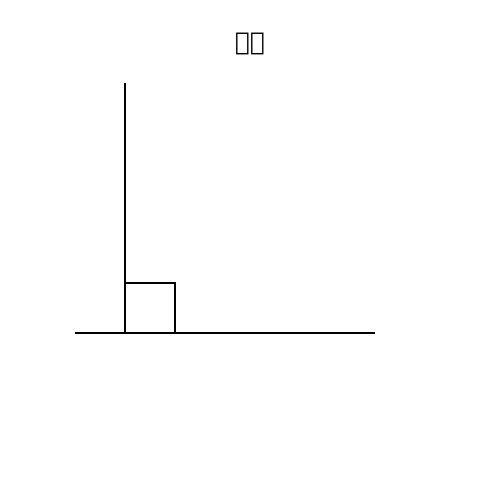

입력된 소단원(section): 수직
추출된 개념: 수직

생성된 설명:
 ### 수직의 개념 이해하기

**정의:**
수직이란 두 선이나 선분이 서로 **직교**하게 만나는 관계를 말합니다. 즉, 한 선이 다른 선과 만나는 각도가 정확히 90도가 되는 것을 의미합니다. 이는 마치 두 개의 직각삼각형의 빗변이 만나는 지점처럼 생각하면 쉽습니다.

**기본 성질:**
1. **직각 형성:** 수직선이 만나는 지점에서는 항상 **직각**이 형성됩니다. 이는 90도의 각도를 가지며, 이는 모든 수직 관계에서 공통적으로 나타나는 특징입니다.
   
2. **평행선과의 관계:** 수직선은 평행선과 만나면 **교차점에서 직각**을 만듭니다. 예를 들어, 한 직선이 다른 직선과 수직으로 만나면 그 교차점에서는 항상 90도의 각도가 생깁니다.

3. **도형 내 적용:** 수직선은 다양한 도형에서 찾아볼 수 있습니다. 예를 들어, 직사각형이나 정사각형의 모서리는 모두 수직 관계를 보여줍니다. 또한, 삼각형에서도 직각삼각형의 두 직각변은 수직입니다.

이러한 이해를 바탕으로 학생들은 실제 도형을 관찰하거나 그릴 때 수직 관계를 쉽게 파악하고 적용할 수 있게 됩니다. 이를 통해 공간 인식 능력도 향상될 수 있습니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">수직</text>
        <!-- 기준선 -->
        <line x1="75" y1="333" x2="375" y2="333" stroke="black" stroke-width="2" />
        <!-- 기울어진 선 -->
        <line x1="125.00000000000001" y1="333" x2="125.00000000000001" y2="83.0" stroke="black" 

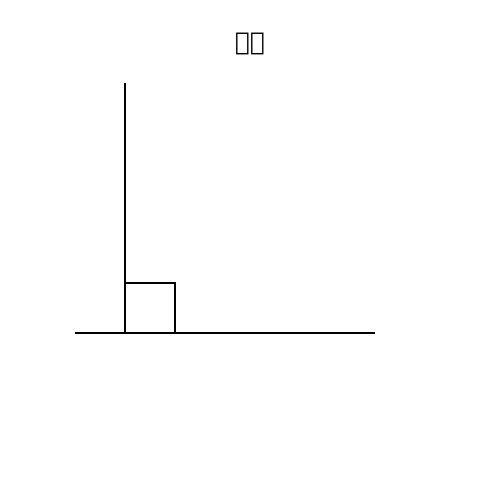

입력된 소단원(section): 삼각자를 사용하여 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 안녕하세요! 오늘은 초등학생들이 쉽게 이해할 수 있도록 **평행선 그리기**에 대해 설명해 드릴게요.

**정의:**

평행선이란 서로 만나지 않고 같은 방향으로 무한히 뻗어나가는 선들을 말해요. 마치 기차 선로처럼요!

**기본 성질:**

1. **같은 방향:** 평행선은 항상 같은 방향으로 뻗어나가요. 마치 친구들이 같은 길을 따라 걸어가는 것처럼요!

2. **거리 유지:** 평행선 사이의 거리는 항상 같아요. 마치 두 개의 평행한 벽 사이의 간격이 항상 일정한 것처럼요!

삼각자를 이용하면 이 평행선을 그리는 게 훨씬 쉬워져요! 

* **직선 그리기:** 먼저 원하는 길이의 직선을 그립니다.
* **각도 맞추기:** 삼각자의 한 각을 이용해 직선 위에 정확하게 맞춥니다.
* **반복:** 같은 각도로 다른 직선을 그려주면 두 직선은 서로 평행하게 그려집니다. 마치 두 친구가 같은 방향으로 손을 뻗는 것처럼요!

평행선 그리기 연습을 통해 공간 감각과 정확성을 키울 수 있답니다. 잘 따라 해보세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125" y1="125" x2="375" y2="125" stroke="

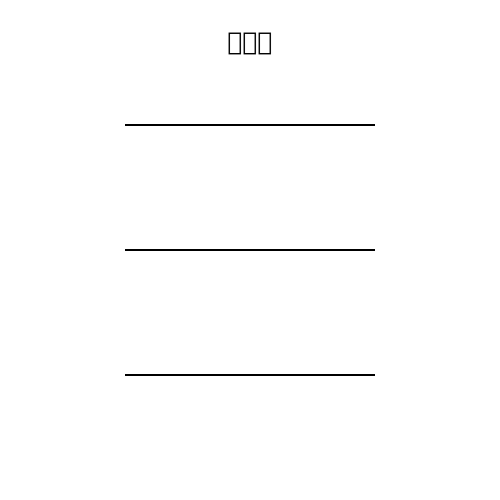

입력된 소단원(section): 주어진 거리의 평행선 긋기
추출된 개념: 평행선

생성된 설명:
 안녕하세요! 오늘은 자와 삼각자를 이용해 평행선을 그리는 방법에 대해 배워볼게요. 이 과정은 기하학에서 매우 기본적이면서도 중요한 기술이에요.

### 정의
**평행선 그리기**는 주어진 거리만큼 떨어진 두 직선이 서로 만나지 않고 항상 같은 방향을 유지하도록 그리는 것을 말해요. 이때, 자와 삼각자는 정확한 거리와 각도를 유지하는 데 필수적인 도구들이에요.

### 기본 성질 및 방법
1. **직선 그리기**: 먼저, 종이 위에 첫 번째 직선을 그립니다. 이 직선을 기준선이라고 부르겠습니다.
   
2. **거리 설정**: 삼각자를 사용해 원하는 거리를 측정합니다. 예를 들어, 5cm의 거리를 원한다면 삼각자의 한쪽 끝을 기준선의 한 점에 맞추고, 다른 끝을 원하는 거리만큼 떨어진 곳에 위치시킵니다.

3. **각도 맞추기**: 삼각자의 한 변을 기준선에 평행하게 맞춥니다. 이때 삼각자의 다른 변이 기준선과 이루는 각도를 정확히 맞춥니다. 이 각도는 평행선이 서로 같은 방향을 유지하도록 하는 핵심입니다.

4. **두 번째 직선 그리기**: 자로 측정한 거리만큼 떨어진 위치에 새로운 점을 표시하고, 이 점을 중심으로 삼각자의 각도를 유지하면서 직선을 그립니다. 이렇게 하면 첫 번째 직선과 새로운 직선은 주어진 거리만큼 떨어져 있고, 서로 평행하게 그려집니다.

이렇게 자와 삼각자를 활용하면 정확한 거리와 각도를 유지하면서 쉽게 평행선을 그릴 수 있어요. 연습을 통해 점점 더 정교하게 그릴 수 있게 될 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="

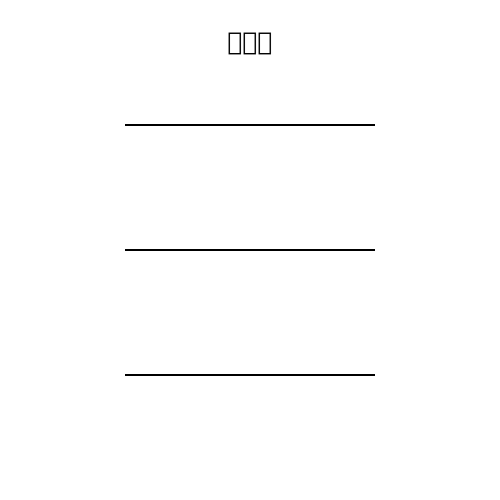

입력된 소단원(section): 평행 알아보기
추출된 개념: 평행선

생성된 설명:
 ### 평행선의 정의와 기본 성질

**정의:**
평행선은 서로 만나지 않고 항상 일정한 거리를 유지하면서 무한히 이어지는 두 직선을 말합니다. 쉽게 말해, 만약 한 직선이 다른 평면 위에 놓여 있다면, 그 직선과 완전히 겹치지 않고 항상 일정한 방향으로 떨어져 있는 다른 직선들이 바로 평행선입니다.

**기본 성질:**
1. **거리 유지:** 평행선은 서로 만나지 않고 항상 일정한 거리(간격)를 유지합니다. 이 거리는 두 직선이 만나는 점에서 무한히 멀어지는 방향으로 일정하게 이어집니다.
   
2. **교차하지 않음:** 평행선은 절대 교차하지 않습니다. 만약 한 직선이 다른 직선과 만나려고 하면, 그 순간부터는 그 직선들이 평행하게 유지됩니다.

3. **공통 점 없음:** 평행선은 공통의 점을 갖지 않습니다. 즉, 한 직선 위의 어떤 점이 다른 평행선 위에 있을 수는 없습니다.

이러한 성질들로 인해 평행선은 기하학에서 매우 중요한 개념으로, 다양한 도형의 성질을 이해하는 데 큰 도움이 됩니다. 이를 통해 학생들은 공간 인식 능력을 키우고, 수학적 사고력을 발전시킬 수 있습니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선들 -->
        <line x1="125" y1="250" x2="375" y2="250" stroke="black" stroke-width="2" />
        <line x1="125

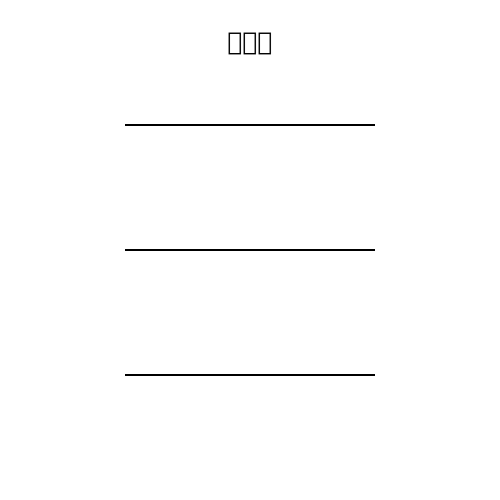

입력된 소단원(section): 평행선 사이의 거리 알아보기
추출된 개념: 평행선 사이의 거리

생성된 설명:
 ## 평행선 사이의 거리:  두 직선이 영원히 만나지 않는 친구들!

친구들, 오늘은 평행선 사이의 신비로운 거리에 대해 알아볼 거예요! 

**정의:** 평행선은 서로 만나지 않고 영원히 같은 방향으로 뻗어나가는 직선 친구들을 말해요. 마치 옆에 있는 두 개의 거울처럼요!

**기본 성질:**

* **같은 거리 유지:** 평행선 사이의 거리는 항상 같아요. 마치 친구들이 항상 같은 간격으로 서 있는 것처럼요!
* **직선을 따라 측정:** 평행선 사이의 거리는 **직선**을 따라 측정할 수 있어요. 마치 친구들 사이의 거리를 재는 줄자처럼요!

**예시:**

* **도로와 건물:** 도로가 평행하게 뻗어있고, 그 사이에 건물들이 있다면, 도로와 건물 사이의 거리는 항상 같아요.
* **책 페이지:** 책 페이지가 평행하게 펼쳐져 있을 때, 페이지 사이의 간격도 일정해요.

평행선 사이의 거리를 알면 건축이나 디자인에서 유용하게 활용할 수 있어요!  

**기억하세요!** 평행선 사이의 거리는 항상 일정하다는 것을 잊지 마세요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행선 사이의 거리</text>
        <!-- 기준선 -->
        <line x1="125" y1="375" x2="375" y2="375" stroke="black" stroke-width="2" />
        <!-- 기준선과 평행선 -->
        <line x1="125" y1="125" x2="375" y2="125" stroke="black" stroke-width="2" />
        <!-- 거리 -->
        <lin

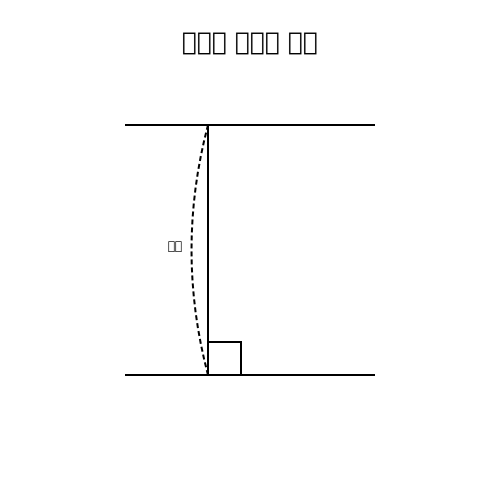

입력된 소단원(section): 직사각형의 성질 알아보기
추출된 개념: 직사각형의 성질

생성된 설명:
 ### 직사각형의 정의와 성질

**정의:**
직사각형은 네 개의 변으로 이루어진 도형으로, 그 중 **두 쌍의 대변이 각각 평행하고 길이가 같은** 특별한 사각형입니다. 쉽게 말해, 직사각형은 네 개의 각이 모두 직각(90도)인 사각형입니다. 예를 들어, 책이나 책상 위에 놓인 물건들이 직사각형 형태를 많이 띠고 있습니다.

**기본 성질:**
1. **대변의 길이 동일:** 직사각형의 두 쌍의 대변은 길이가 같습니다. 즉, 만약 한 쌍의 대변이 길이가 \(a\)라면 다른 쌍의 대변도 길이가 \(a\)입니다.
   
2. **대각선의 길이 동일:** 직사각형의 두 대각선은 길이가 같습니다. 이는 직사각형의 대칭성 때문에 자연스럽게 나타나는 성질입니다. 만약 대각선의 길이를 \(d\)라고 하면, 두 대각선의 길이는 항상 \(d\)입니다.

3. **직각 각:** 모든 내각이 직각(90도)입니다. 따라서 각은 항상 90도입니다.

4. **면적 계산:** 직사각형의 면적은 길이와 너비를 곱한 값으로 계산됩니다. 공식은 \( \text{면적} = \text{길이} \times \text{너비} \)입니다. 여기서 길이와 너비는 서로 바뀔 수 있습니다.

이러한 성질들 덕분에 직사각형은 일상생활에서 매우 흔하게 볼 수 있으며, 이해하기 쉽고 분류하기도 용이합니다. 이러한 지식을 바탕으로 다양한 도형을 정확하게 식별하고 분류하는 능력을 키울 수 있습니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">직사각형의 성질</text>
        <rect x="100" y="100" width="300" height="150" stroke="black" strok

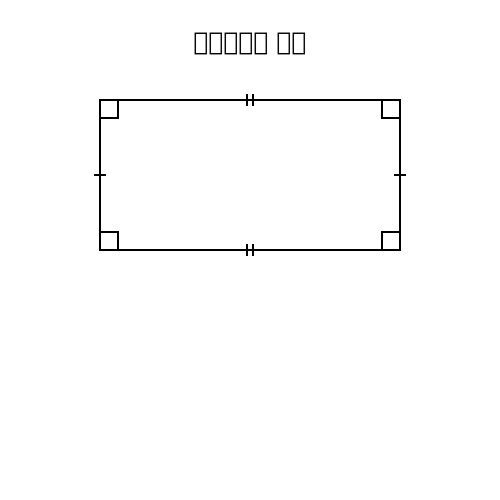

입력된 소단원(section): 정사각형의 성질 알아보기
추출된 개념: 정사각형의 성질

생성된 설명:
 ## 정사각형 탐험! 🎉

안녕하세요, 친구들! 오늘은 특별한 사각형인 **정사각형**에 대해 알아볼 거예요!

**정의:** 정사각형은 네 개의 **모두 같은 길이**를 가진 변으로 이루어진 사각형이에요. 마치 네 개의 똑같은 블록을 붙여서 만든 모양이죠!

**성질 탐험!**

* **변:** 정사각형의 네 변은 모두 **같은 길이**를 가지고 있어요. 마치 친구들과 줄을 서서 모두 같은 간격으로 서 있는 것처럼요!
* **각:** 정사각형의 네 각은 모두 **직각**으로 90도예요. 마치 네 개의 뾰족한 모서리가 있는 모양이죠!
* **대각선:** 정사각형의 대각선은 서로 **같은 길이**를 가지고 있어요. 그리고 대각선은 서로 **교차할 때 직각삼각형**을 만들어요. 마치 퍼즐 조각처럼 딱 맞아떨어지는 거죠!

**다른 사각형과 비교하기**

다른 사각형들과 비교해보면, 정사각형은 특별한 점이 있어요!

* **사각형:** 네 변의 길이가 모두 다를 수 있어요.
* **직사각형:** 네 각이 모두 직각이지만 변의 길이는 다를 수 있어요.
* **평행사변형:** 마주 보는 두 변의 길이가 같지만 각은 다를 수 있어요.

정사각형은 모든 면이 똑같아서 정말 특별한 도형이죠! 🎉

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">정사각형의 성질</text>
        <rect x="100" y="100" width="300" height="300" stroke="black" stroke-width="2" fill="none" />
        <!-- 직각 보조선들 -->
        <polyline points="137, 100 137, 137

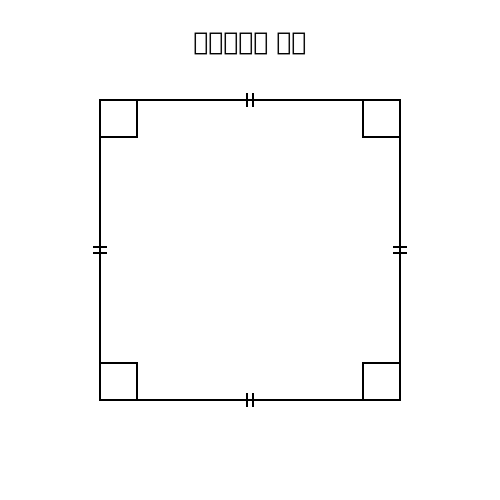

입력된 소단원(section): 직사각형과 정사각형의 성질 활용
추출된 개념: 직사각형/정사각형의 성질 활용

생성된 설명:
 ## 둥근 모양의 비밀: 원과 부채꼴로 세상을 이해하기!

안녕하세요, 친구들! 오늘은 둥근 모양이 우리 주변에서 얼마나 중요한지 알아보려고 해요. 특히 **원**과 **부채꼴**이라는 두 가지 둥근 도형을 통해 실생활 문제를 해결하는 방법을 배워볼게요.

**1. 원:**

* **정의:** 원은 평면 위에서 한 점(중심)으로부터 일정한 거리(반지름)에 있는 모든 점들의 집합이에요. 마치 태양처럼 둥글게 빛나는 모양이죠!
* **기본 성질:**
    * **둘레와 지름:** 원의 둘레는 지름의 두 배예요. 쉽게 말해, 원의 가장자리 길이를 측정하면 지름을 구하고 그 값을 두 배로 하면 둘레 길이를 알 수 있어요!
    * **넓이:** 원의 넓이는 π(3.14) 곱하기 반지름 제곱으로 계산할 수 있어요. 마치 케이크를 자르듯이 원을 여러 조각으로 나누어 각 조각의 넓이를 더하면 전체 넓이를 구할 수 있답니다!

**2. 부채꼴:**

* **정의:** 원을 두 개의 같은 크기의 삼각형으로 나눈 부분이 바로 부채꼴이에요. 마치 태양을 반으로 자른 모양처럼 생겼어요!
* **기본 성질:**
    * **중심각:** 부채꼴의 중심각은 원의 중심에서 시작해서 부채꼴의 가장자리까지 이어지는 각도예요. 이 각도를 알면 부채꼴의 크기를 예측할 수 있어요.
    * **넓이:** 부채꼴의 넓이는 전체 원의 넓이에 중심각을 360도로 나눈 비율을 곱한 값이에요. 마치 태양이 하늘을 얼마나 차지하는지 생각하면 이해하기 쉬울 거예요!

**실생활 예시:**

* **자전거 바퀴:** 자전거 바퀴는 원 모양이에요. 바퀴의 지름을 알면 둘레를 계산하여 자전거가 한 바퀴 돌 때 이동하는 거리를 알 수 있죠!
* **피자 자르기:** 피자를 여러 조각으로 나눌 때 부채꼴 개념을 활용해요. 피자의 중심각을 알면 각 조각의 크기를 예측하고 맛있게 나눠 먹을

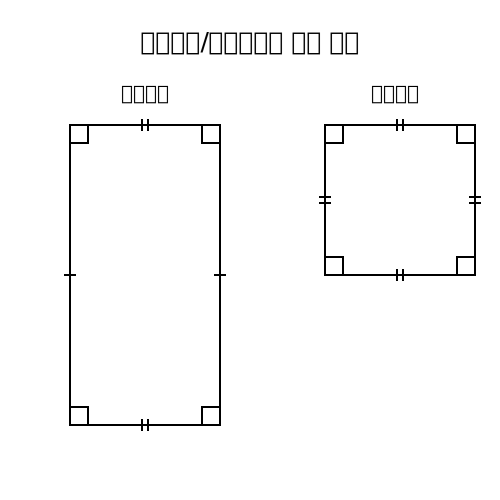

입력된 소단원(section): 사다리꼴 알아보기
추출된 개념: 사다리꼴

생성된 설명:
 ### 사다리꼴의 정의와 기본 성질

**정의:**
사다리꼴은 평면 위에서 네 개의 변으로 이루어진 도형으로, 그 중 두 쌍의 대변이 평행합니다. 쉽게 말해, 사다리꼴은 한쪽 끝에서 다른 끝까지 이어지는 두 개의 평행한 변(밑변) 사이에 두 개의 다른 길이의 변(옆변)이 위치하는 도형입니다. 이 평행한 변들 사이의 거리가 일정하지 않아도 됩니다.

**기본 성질:**

1. **밑변과 옆변:**
   - 사다리꼴은 두 개의 밑변을 가지고 있으며, 이 밑변들은 평행합니다. 밑변의 길이는 서로 다를 수 있습니다.
   - 밑변 사이에 위치한 두 개의 옆변은 평행하며, 이들의 길이도 서로 다를 수 있습니다.

2. **높이:**
   - 사다리꼴의 평행한 두 밑변 사이의 거리를 **높이**라고 부릅니다. 이 높이는 사다리꼴을 두 개의 직각삼각형으로 나눌 수 있게 해줍니다. 각 직각삼각형의 높이는 밑변의 길이 차이를 밑변의 길이로 나눈 값입니다.

3. **면적 공식:**
   - 사다리꼴의 면적은 밑변의 길이와 높이를 이용해 계산할 수 있습니다. 공식은 다음과 같습니다:
     \[
     \text{면적} = \frac{1}{2} \times (\text{윗변} + \text{아랫변}) \times \text{높이}
     \]
   - 여기서 윗변과 아랫변은 평행한 두 밑변을 의미합니다. 이 공식을 통해 학생들은 사다리꼴의 크기를 쉽게 계산할 수 있습니다.

이러한 성질들을 이해하면 사다리꼴의 모양과 그 면적을 계산하는 데 큰 도움이 됩니다. 특히, 평행한 변과 높이를 활용하는 방법을 익히면 다양한 문제 해결 능력이 향상될 것입니다!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor=

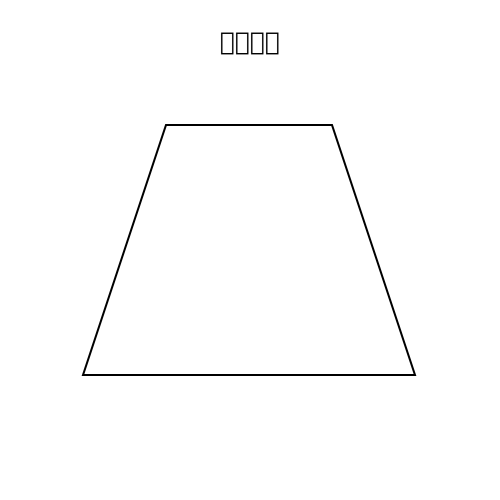

입력된 소단원(section): 평행사변형의 성질 알아보기
추출된 개념: 평행사변형

생성된 설명:
 ## 평행사변형 친구들! 🎉

안녕하세요! 오늘은 우리 주변에서 쉽게 찾아볼 수 있는 **평행사변형**에 대해 알아볼 거예요! 

**1. 평행사변형이란?**

평행사변형은 **두 쌍의 마주 보는 변이 평행**한 사각형이에요. 마치 옆으로 뻗은 사다리처럼요! 

**2. 평행사변형의 특징**

* **평행한 변:**  두 쌍의 변이 서로 평행하게 이어져 있어요. 마치 거울처럼요!
* **같은 길이의 대변:** 마주 보는 두 변의 길이가 같아요. 마치 쌍둥이처럼 똑같죠!
* **대각선이 서로를 이등분:** 평행사변형의 대각선은 서로를 반으로 잘라요. 마치 가위로 자르는 것처럼요!
* **내각의 합:** 평행사변형의 네 내각의 합은 항상 **360도**예요. 마치 퍼즐 조각처럼 딱 맞아떨어지는 거죠!

평행사변형을 잘 살펴보면서 주변에서 찾아볼 수 있는 예시들을 찾아보세요!  

예를 들어, 책의 표지, 창문의 모양, 심지어는 우리 몸의 다리 모양도 평행사변형의 특징을 가지고 있을 수 있어요! 🎉

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="247.0" y1="115" x2="247.0" y2="135" stroke="black" stroke-width="2" />
        <line x1="251.0" y1="115" x2="251.0" y2="135" stroke="blac

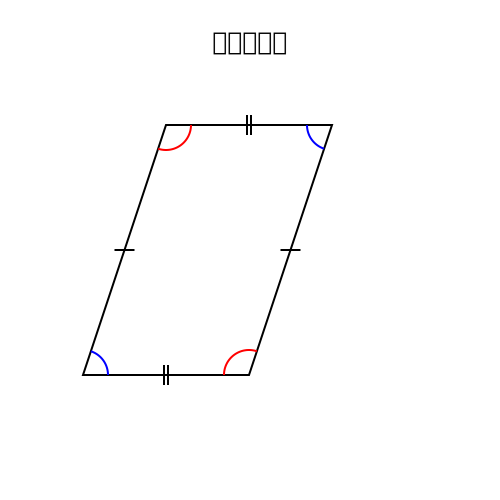

입력된 소단원(section): 평행사변형 알아보기
추출된 개념: 평행사변형

생성된 설명:
 ### 평행사변형의 정의와 특징

**정의:**
평행사변형은 네 개의 변으로 이루어진 도형으로, 그 중 서로 마주 보는 두 변은 길이가 같고 평행합니다. 쉽게 말해, 평행사변형은 한쪽 변을 기준으로 반대편 변들이 정확히 같은 거리에 위치해 있는 사각형입니다.

**주요 특징:**

1. **대변이 평행:**
   - 평행사변형의 가장 중요한 특징 중 하나는 반대편 변들이 서로 평행하다는 것입니다. 즉, 한 쌍의 대변은 서로 만나지 않고 항상 일정한 거리를 유지합니다.

2. **대응하는 변의 길이 동일:**
   - 마주 보는 두 변의 길이가 정확히 같습니다. 예를 들어, 한 변의 길이가 5cm라면 그 반대편 변의 길이도 5cm입니다.

3. **대각선이 서로를 이등분:**
   - 평행사변형의 대각선은 서로를 반으로 나눕니다. 즉, 한 대각선이 평행사변형을 두 개의 삼각형으로 나누면, 그 삼각형의 두 대각선은 서로를 정확히 반으로 나눕니다.

4. **내부 각도의 합:**
   - 평행사변형의 모든 내각의 합은 항상 360도입니다. 이는 사각형의 일반적인 성질과 일치합니다.

이러한 특징들로 인해 평행사변형은 다양한 기하학적 문제 해결과 실생활에서의 응용이 가능합니다. 예를 들어, 건축에서의 구조물 설계나 그래픽 디자인에서의 레이아웃 구성 등에 활용됩니다. 이러한 이해를 바탕으로 학생들은 도형의 구조와 성질을 더 잘 파악할 수 있을 것입니다.

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">평행사변형</text>
        <polygon points="166,125 332,125 249,375 83,375" stroke="black" stroke-width="

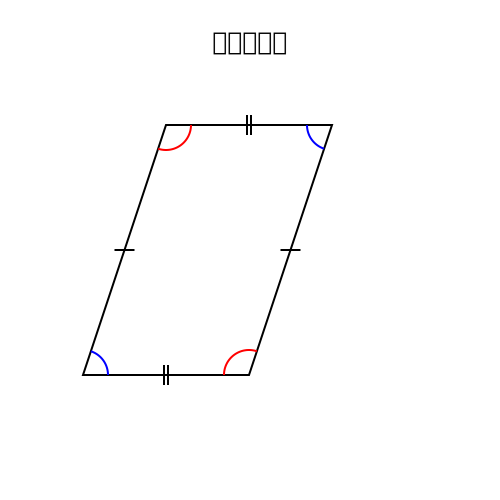

입력된 소단원(section): 마름모 알아보기
추출된 개념: 마름모

생성된 설명:
 ## 마름모, 네 변 모두 친구처럼!

**정의:** 마름모는 **사각형의 특별한 친구**라고 생각하면 돼요! 

네 변의 길이가 모두 같고, **대각선이 서로 수직으로 만나는 사각형**이 바로 마름모예요. 마치 퍼즐 조각처럼 네 변이 딱 맞아떨어지는 모습이죠!

**성질:**

* **모든 변의 길이가 같아요:** 마름모는 마치 친구들처럼 모두 같은 길이의 옷을 입고 있어요!
* **대각선은 서로 수직이에요:** 마름모의 대각선은 마치 친구들끼리 손을 잡고 서 있는 것처럼 서로 직각으로 만나요.
* **대각선이 마름모를 두 개의 똑같은 삼각형으로 나눠요:** 대각선을 그리면 마름모는 두 개의 똑같은 삼각형으로 나뉘어져요. 마치 퍼즐 조각을 맞춘 것처럼요!
* **내각의 합은 항상 360도예요:** 마름모 안에 있는 네 각의 합은 항상 360도라는 규칙을 기억해요!

마름모를 보면서 네 변이 모두 같고 대각선이 수직으로 만나는 특별한 모양임을 기억하면 쉽게 구별할 수 있을 거예요!

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-width="2" />
        <line x1="327.0076729

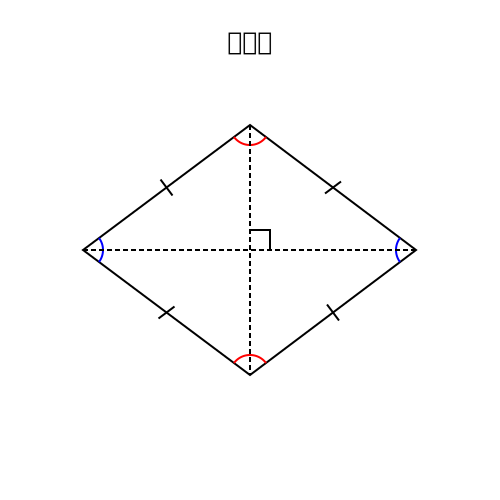

입력된 소단원(section): 마름모의 성질 알아보기
추출된 개념: 마름모

생성된 설명:
 ## 마름모 대각선의 비밀을 밝혀요! 🎉

마름모는 네 변의 길이가 모두 같은 특별한 도형이에요! 이 마름모의 대각선은 마치 마름모를 두 개의 삼각형으로 나누는 마법의 선이랍니다. 

**정의:** 마름모의 대각선은 마름모의 두 꼭지점을 잇는 선분이에요. 마치 마름모를 자르면 나타나는 두 개의 똑같은 삼각형 모양이죠!

**대각선 성질:**

1. **대각선은 서로를 이등분해요:** 마름모의 대각선은 서로를 정확히 반으로 잘라요. 마치 가위로 자르듯이요! 그래서 각 삼각형의 두 변의 길이가 같아져요.

2. **대각선은 서로 수직이에요:** 마름모의 대각선은 서로 직각으로 만나요. 마치 퍼즐 조각처럼 딱 맞아떨어지는 거죠!

이 성질들을 알면 마름모를 더 잘 이해하고, 넓이를 구하거나 다른 문제를 풀 때 유용하게 활용할 수 있어요! 🎯

생성된 코드:
 <svg width="500" height="500" xmlns="http://www.w3.org/2000/svg">
        <text x="250" y="50" font-size="25" text-anchor="middle">마름모</text>
        <polygon points="250,125 416,250 250,375 83,250" stroke="black" stroke-width="2" fill="none"/>
        <!-- 등변 보조선 -->
        <line x1="160.50767293637523" y1="179.4942510429973" x2="172.49232706362477" y2="195.5057489570027" stroke="black" stroke-width="2" />
        <line x1="327.00767293637523" y1="304.4942510429973" x2="338.99232706362477" y2="320.5057489570027" 

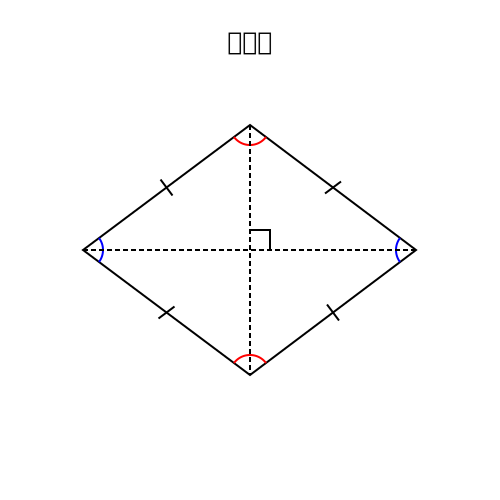

In [30]:
# %%time
# %%timeit -n 5 -r 6

import json
# 그래프 호출
for i, user_input in enumerate(input_samples):
    result = app.invoke({"input_section": user_input})
    
    # 결과 출력
    print("입력된 소단원(section):", result["input_section"])
    print("추출된 개념:", result["math_concept"])
    print("\n생성된 설명:\n", result["comments"])
    if "formulas" in result.keys():
        print("\n생성된 공식 raw:\n", result["formulas"])
        show_formulas(result["formulas"])
    if "generated_code" in result.keys():
        print("\n생성된 코드:\n", result["generated_code"])
        show_svg(result["generated_code"])

    print("=" * 100)